In [51]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [52]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [53]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f"Range of X: {X.min()} ~ {X.max()}")
    break


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Range of X: 0.0 ~ 1.0


In [54]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


class ResidualBlock(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.conv1 = nn.Conv2d(channel, channel, kernel_size=3, padding=1)   # 3x3 same size filtering
        self.bn = nn.BatchNorm2d(channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channel, channel, kernel_size=3, padding=1)  # 3x3 same size filtering

    def forward(self, inp):
        x = self.conv1(inp)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x + inp
        
# Encoder model
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),   # 3x3 same size filtering
            nn.ReLU(),
        )
        self.residual_pool_stack2 = nn.Sequential(
            nn.Conv2d(8, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResidualBlock(32),
            ResidualBlock(32),
            nn.AvgPool2d(2)                               # Downsampling 2x2
        )
        self.residual_pool_stack3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ResidualBlock(64),
            ResidualBlock(64),
            nn.AvgPool2d(2)                              # Downsampling 2x2
        )
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7*7*64, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
    
    def forward(self, x):
        x = self.conv_stack1(x)
        x = self.residual_pool_stack2(x)
        x = self.residual_pool_stack3(x)
        x = self.linear_relu_stack(x)
        return x
        
# Decoder model
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_reverse_stack = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 7*7*64)
        )

        self.residual_upsample_stack1 = nn.Sequential(
            nn.Upsample(scale_factor=2),                           # Upsampling 2x2
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResidualBlock(32),
            ResidualBlock(32),
        )

        self.residual_upsample_stack2 = nn.Sequential(
            nn.Upsample(scale_factor=2),                           # Upsampling 2x2
            nn.Conv2d(32, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            ResidualBlock(8),
            ResidualBlock(8),
        )
        self.reverse_conv_stack = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, padding=1),   # 3x3 same size filtering
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=1, padding=0),   # 3x3 same size filtering
            nn.ReLU(),
            nn.Conv2d(1, 1, kernel_size=3, padding=1),   # 3x3 same size filtering
            nn.Sigmoid()
        )
    
    
    def forward(self, x):
        y = self.linear_reverse_stack(x)
        batch_size = y.shape[0]
        y = y.reshape(batch_size, 64, 7, 7) 
        y = self.residual_upsample_stack1(y)
        y = self.residual_upsample_stack2(y)
        y = self.reverse_conv_stack(y)
        return y

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (encoder): Encoder(
    (conv_stack1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (residual_pool_stack2): Sequential(
      (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ResidualBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): ResidualBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 

In [55]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [56]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, _cat = X.to(device), y.to(device)

        # Compute autoencoder error
        rebuild = model(X)
        loss = loss_fn(X, rebuild)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [57]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, _cat in dataloader:
            X = X.to(device)
            rebuild = model(X)
            test_loss += loss_fn(X, rebuild).item()
    test_loss /= num_batches
    print(f"Test Error: \nAvg loss: {test_loss:>8f} \n")

In [58]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.147272  [   64/60000]
loss: 0.045789  [ 6464/60000]
loss: 0.047453  [12864/60000]
loss: 0.034859  [19264/60000]
loss: 0.039119  [25664/60000]
loss: 0.032889  [32064/60000]
loss: 0.027641  [38464/60000]
loss: 0.023604  [44864/60000]
loss: 0.021241  [51264/60000]
loss: 0.020289  [57664/60000]
Test Error: 
Avg loss: 0.019524 

Epoch 2
-------------------------------
loss: 0.018106  [   64/60000]
loss: 0.015512  [ 6464/60000]
loss: 0.013547  [12864/60000]
loss: 0.014706  [19264/60000]
loss: 0.014239  [25664/60000]
loss: 0.012715  [32064/60000]
loss: 0.013100  [38464/60000]
loss: 0.011401  [44864/60000]
loss: 0.011783  [51264/60000]
loss: 0.012841  [57664/60000]
Test Error: 
Avg loss: 0.012502 

Done!


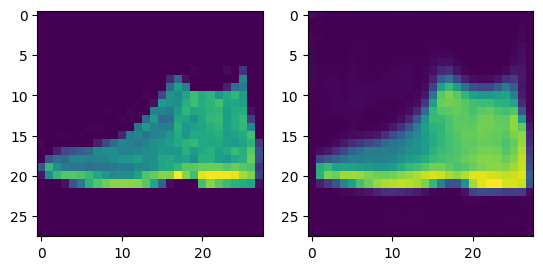

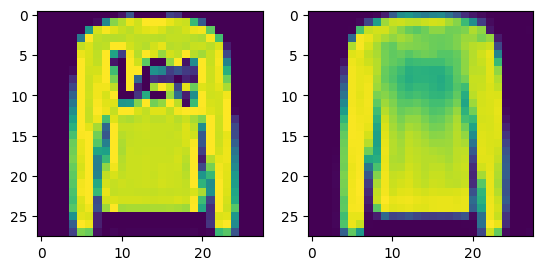

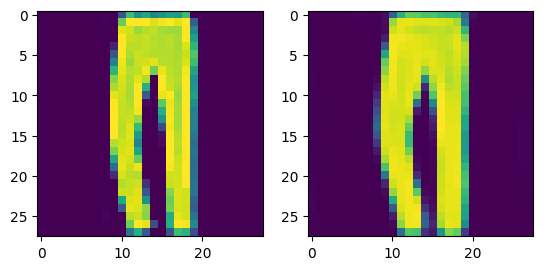

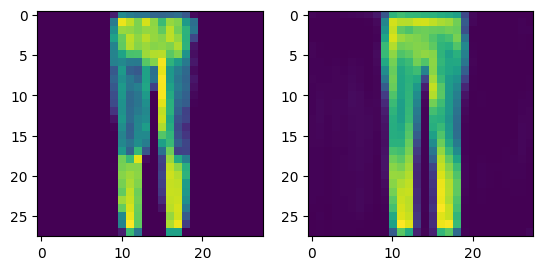

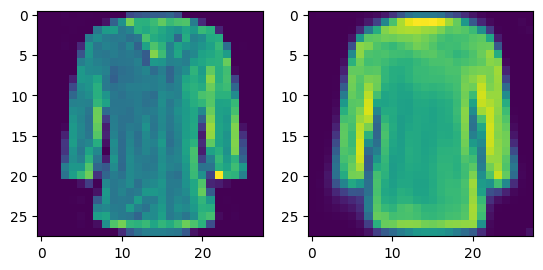

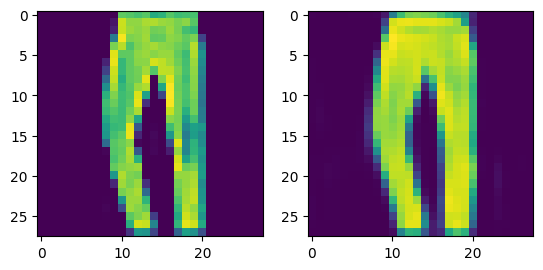

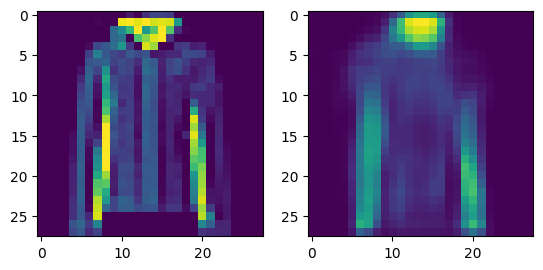

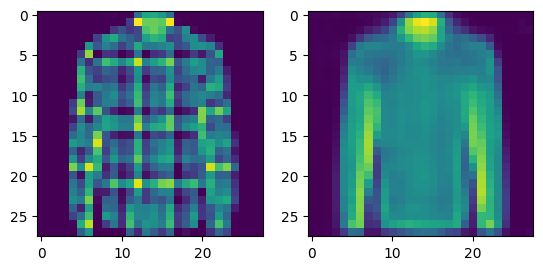

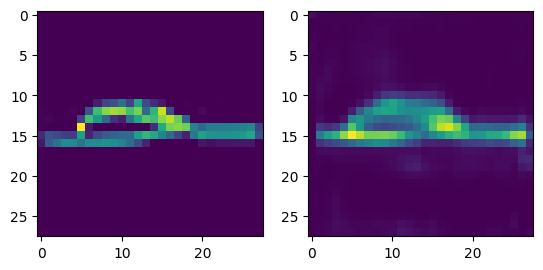

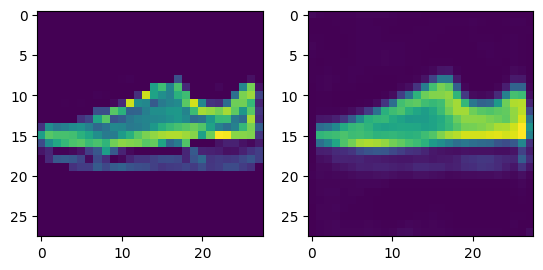

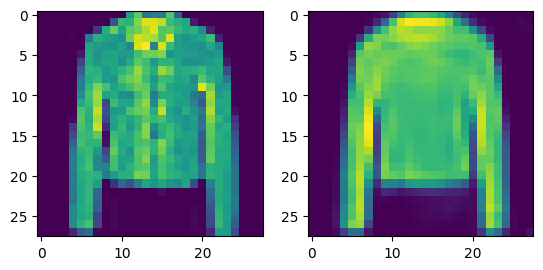

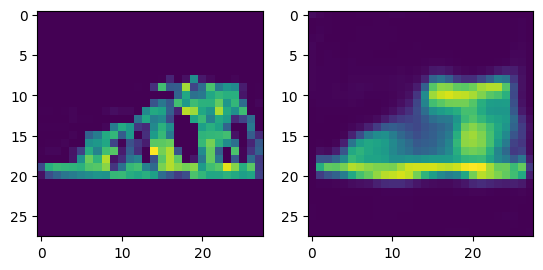

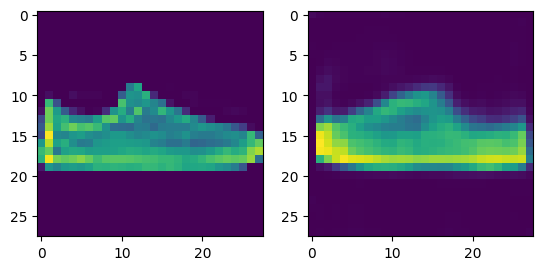

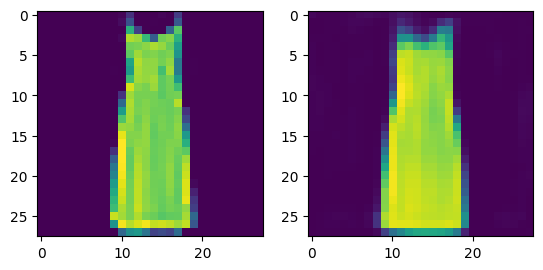

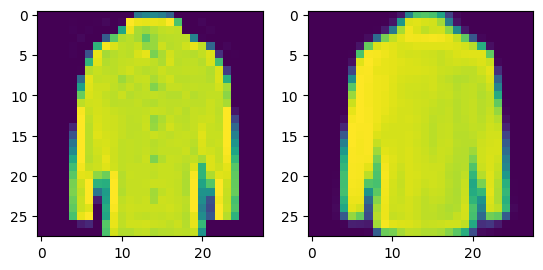

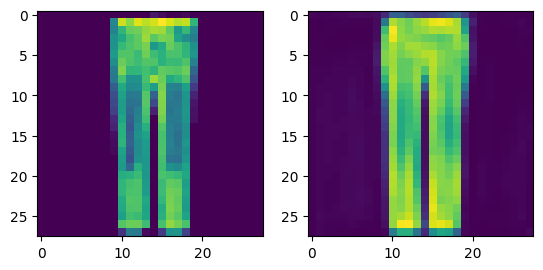

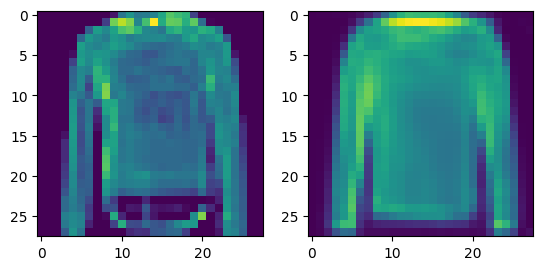

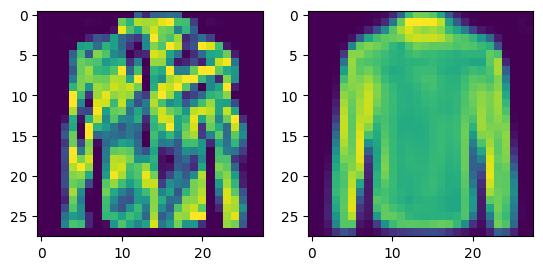

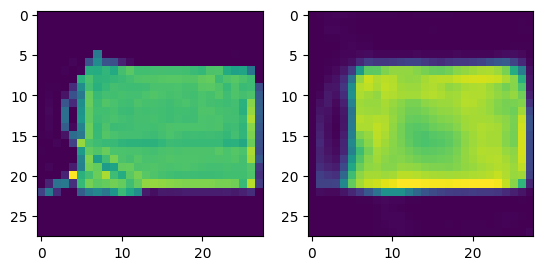

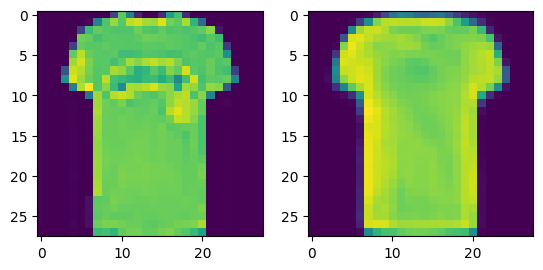

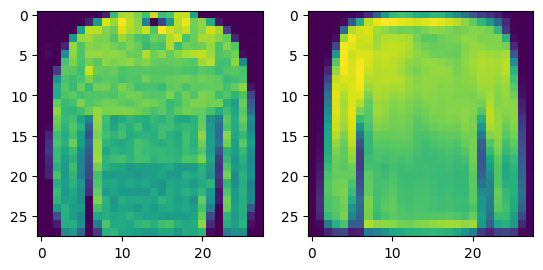

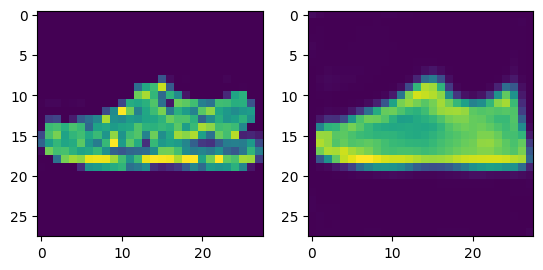

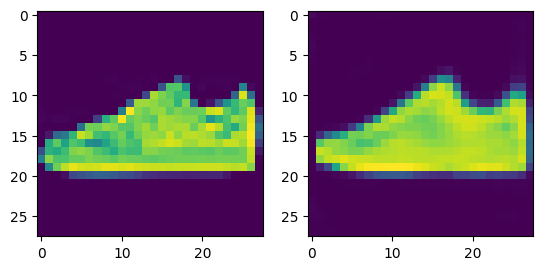

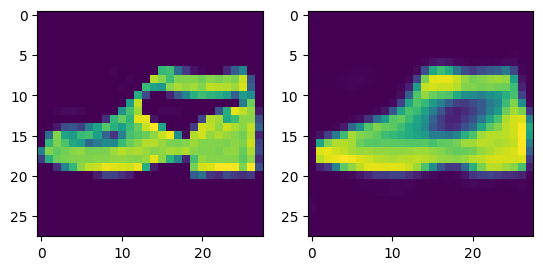

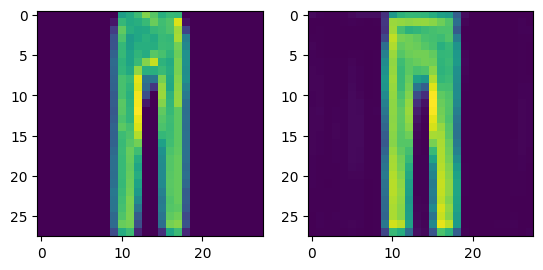

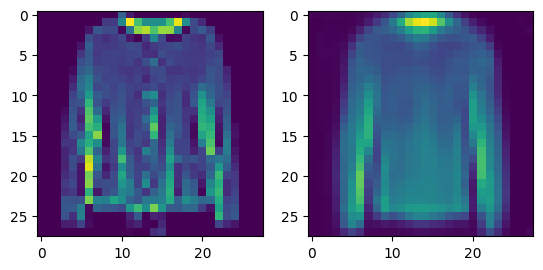

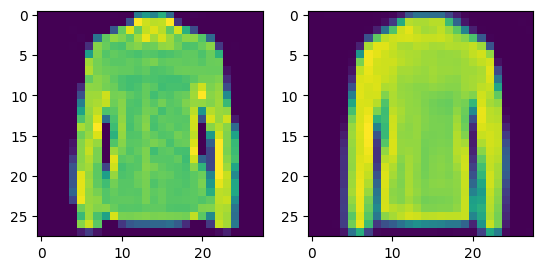

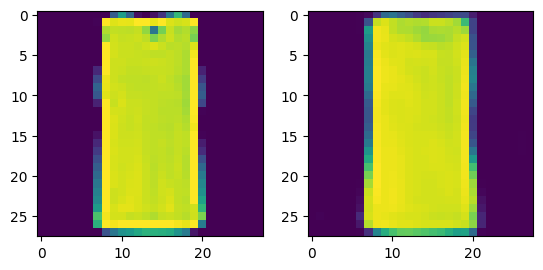

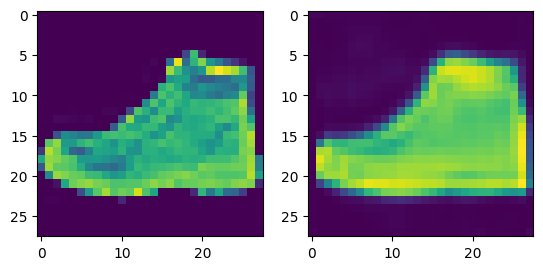

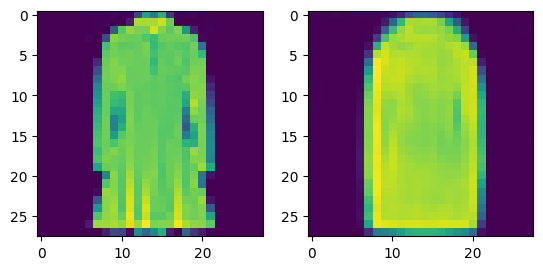

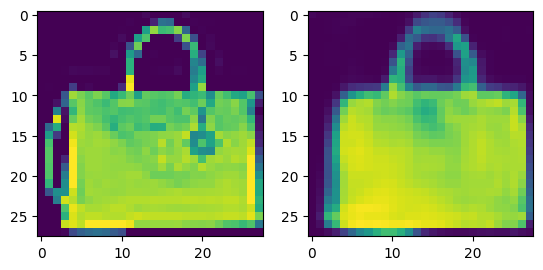

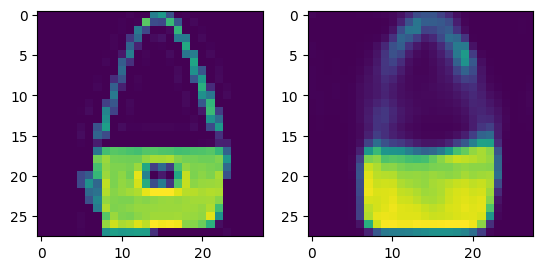

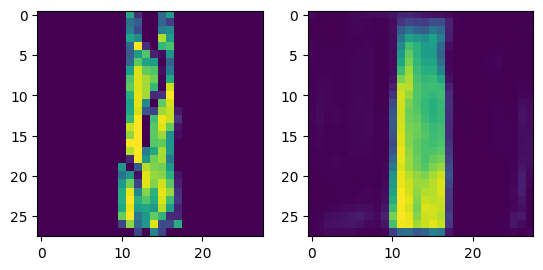

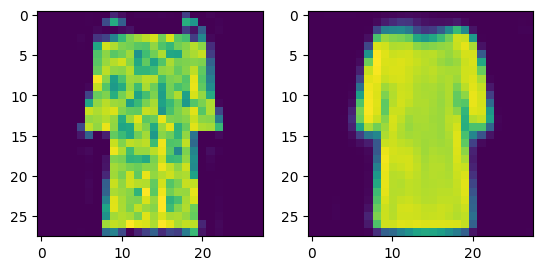

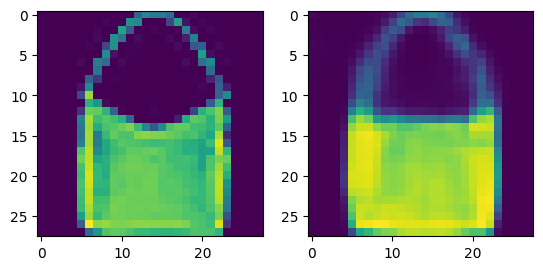

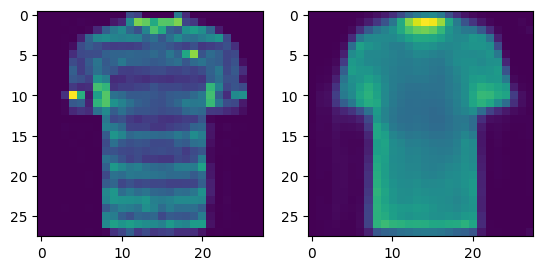

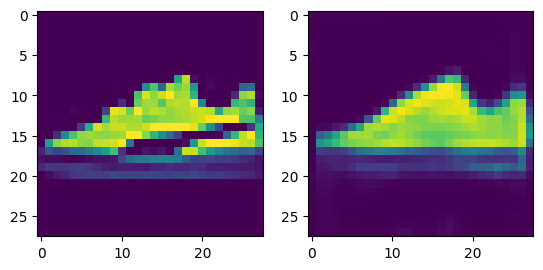

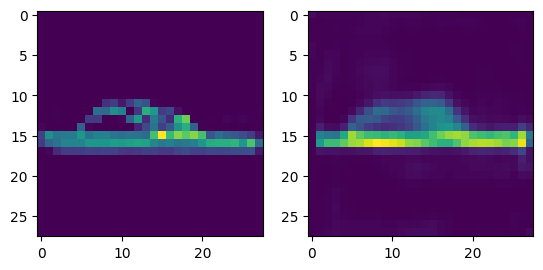

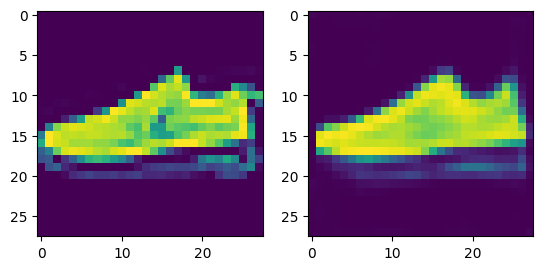

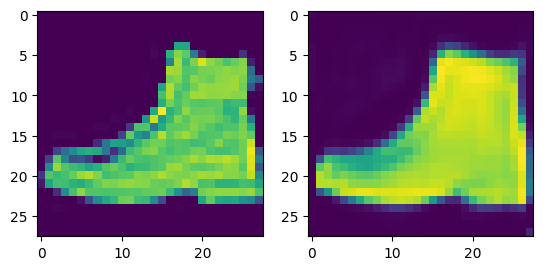

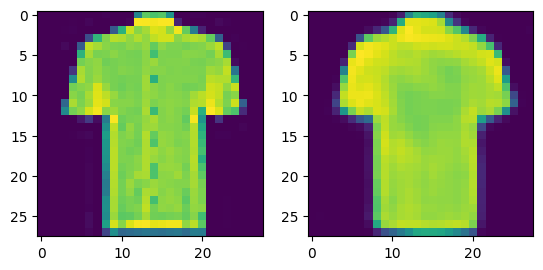

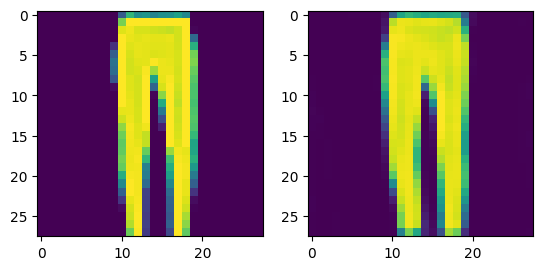

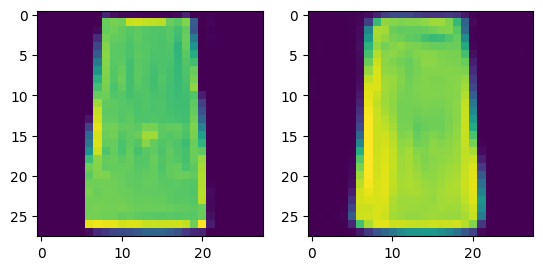

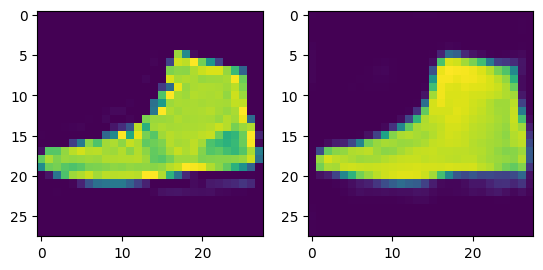

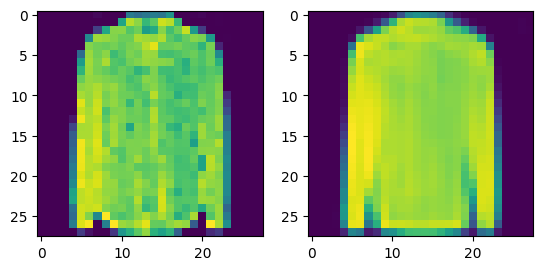

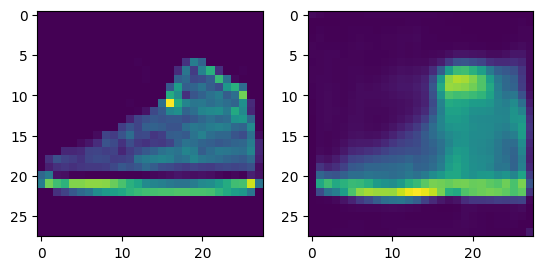

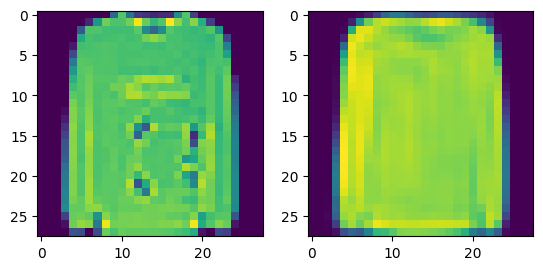

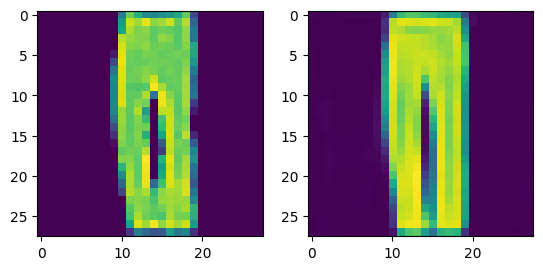

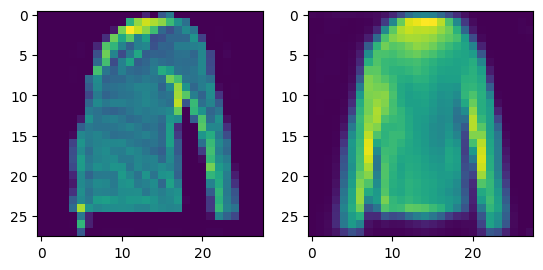

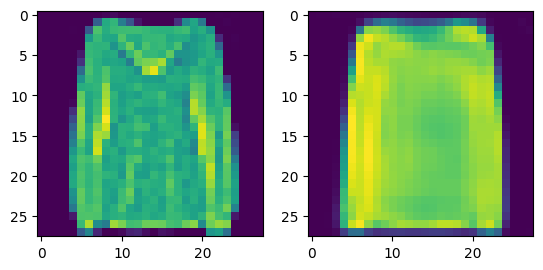

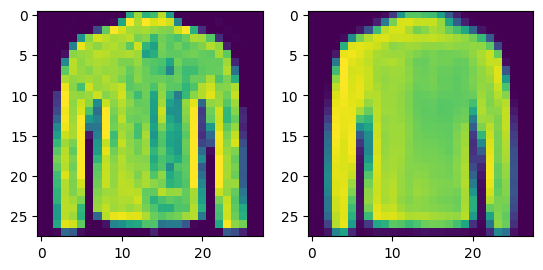

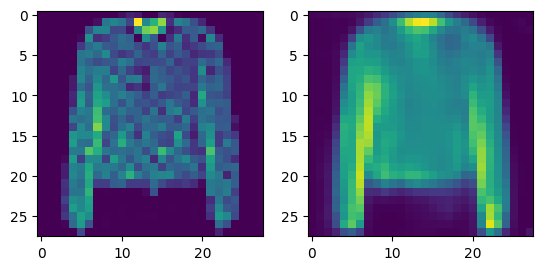

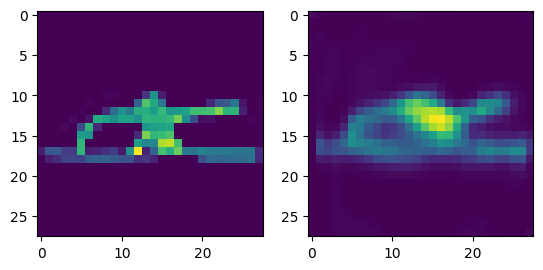

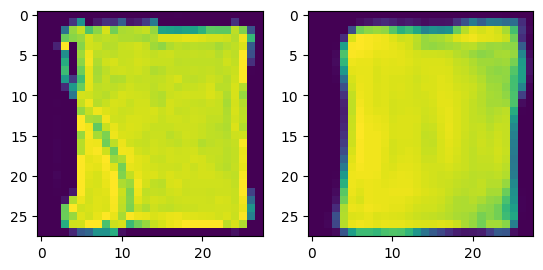

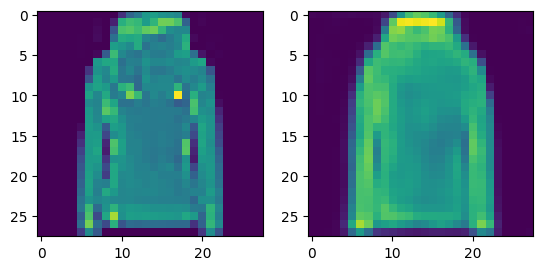

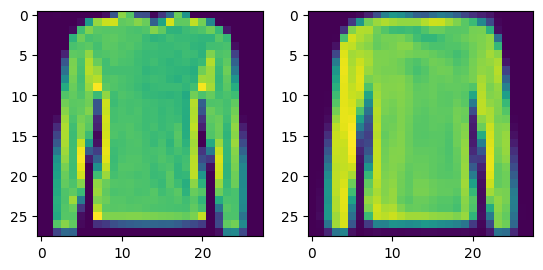

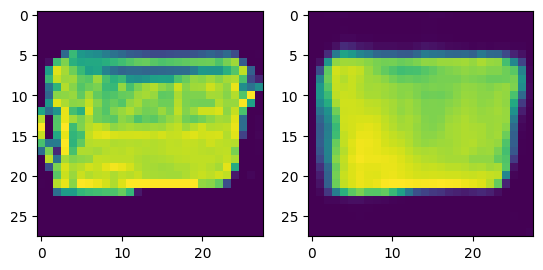

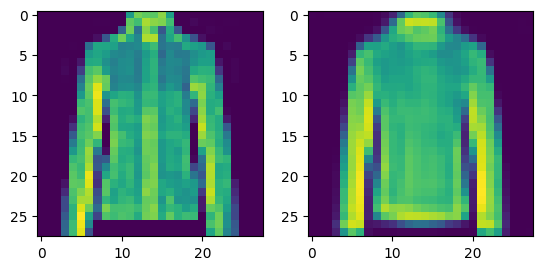

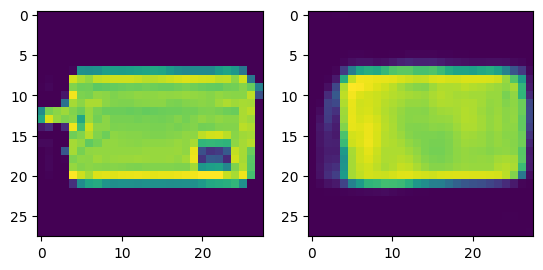

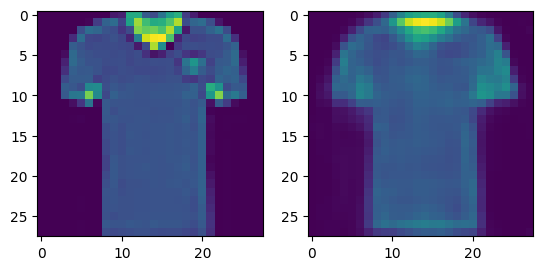

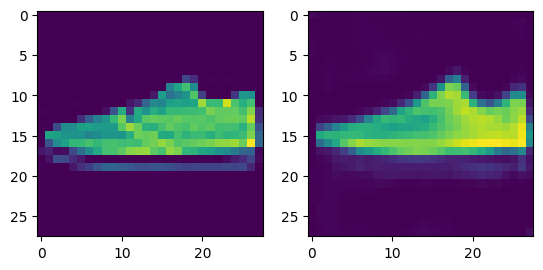

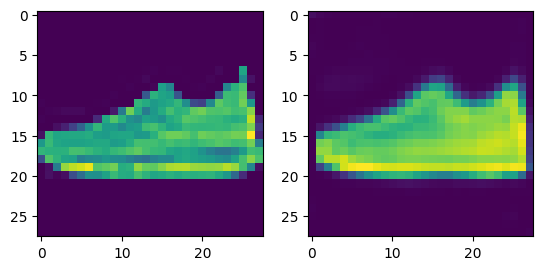

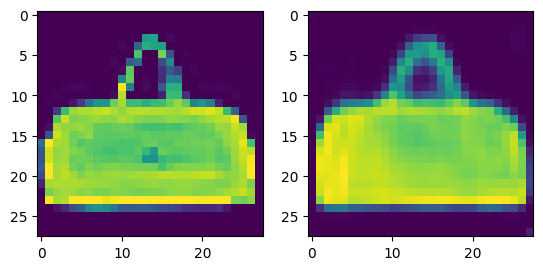

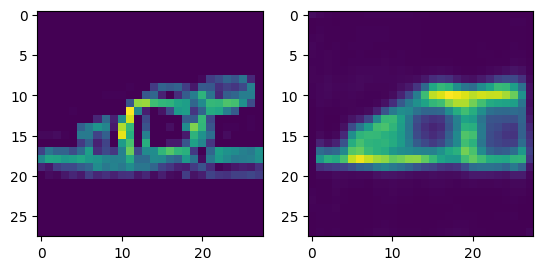

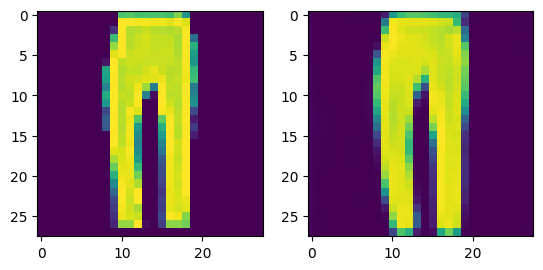

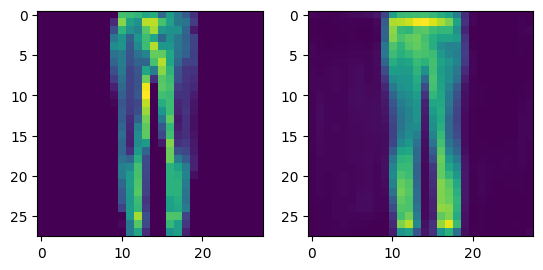

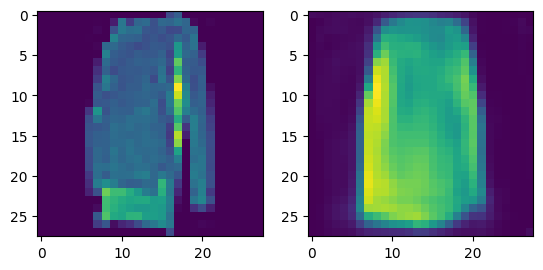

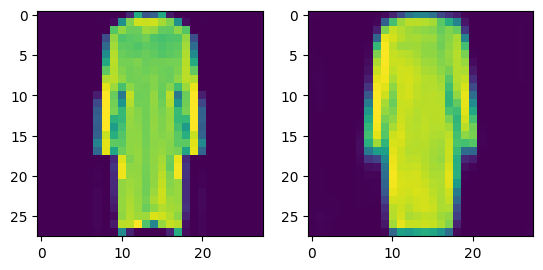

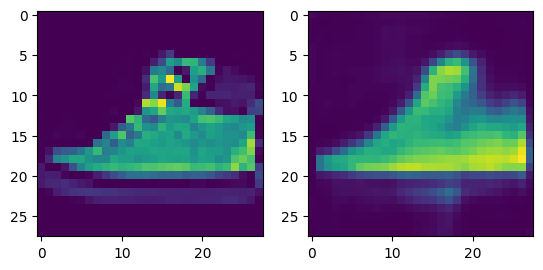

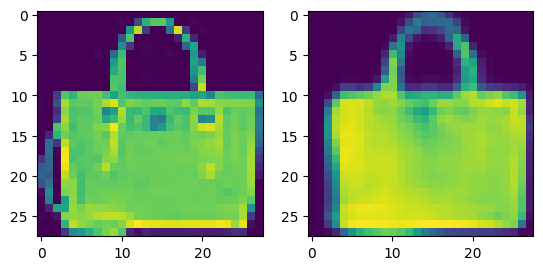

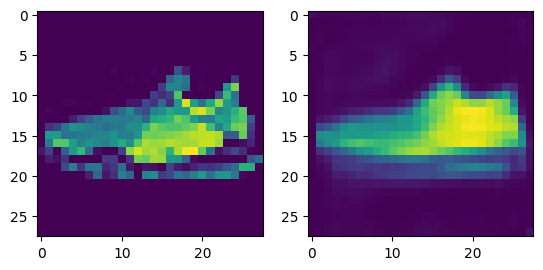

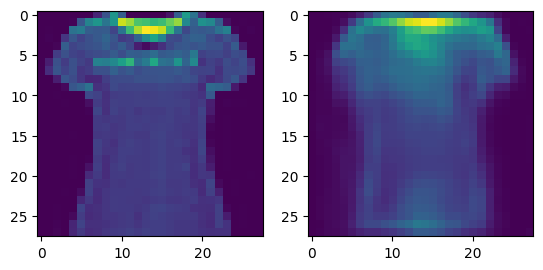

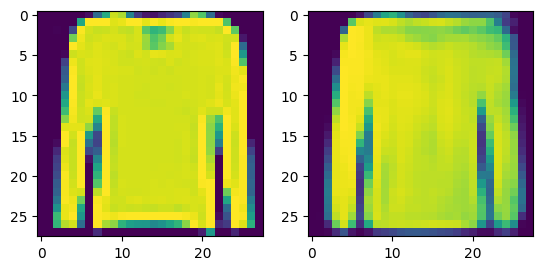

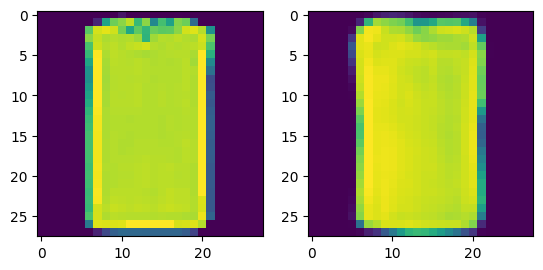

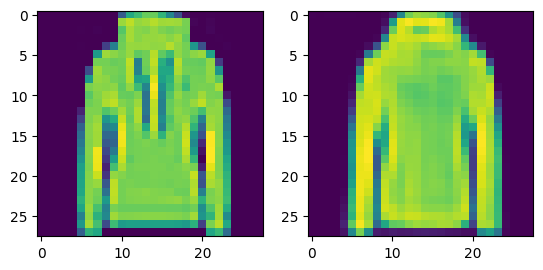

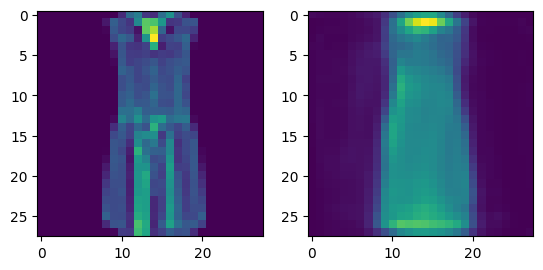

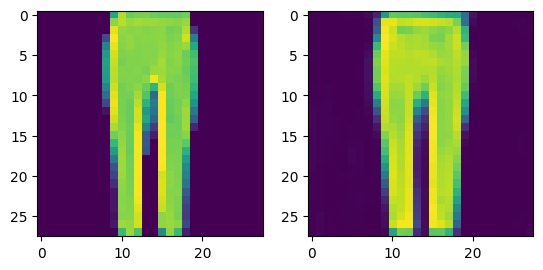

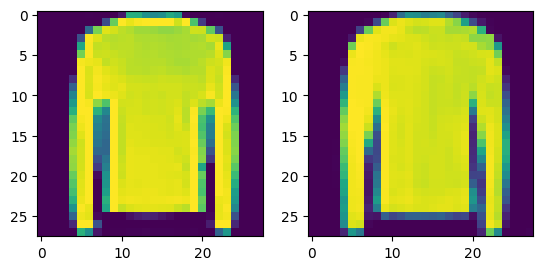

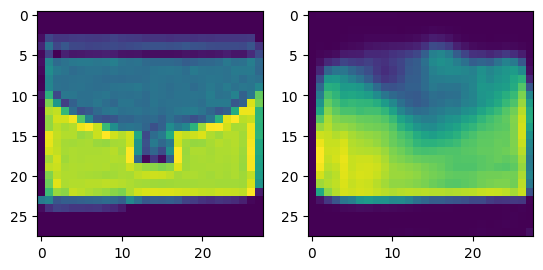

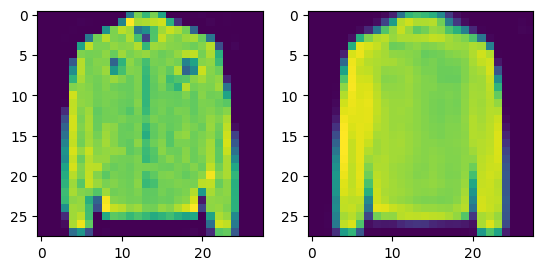

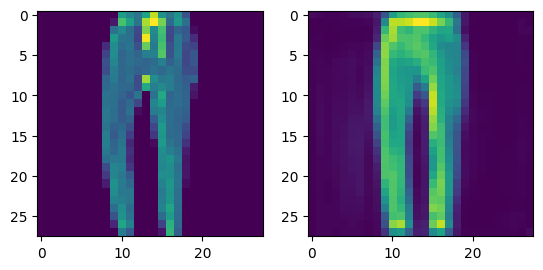

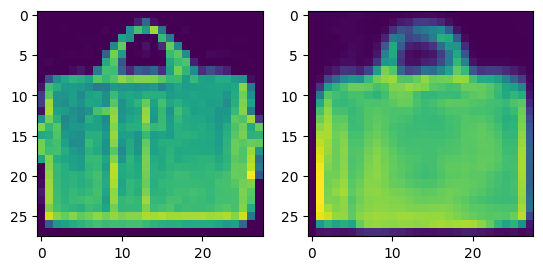

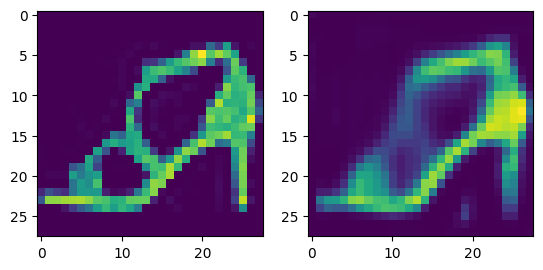

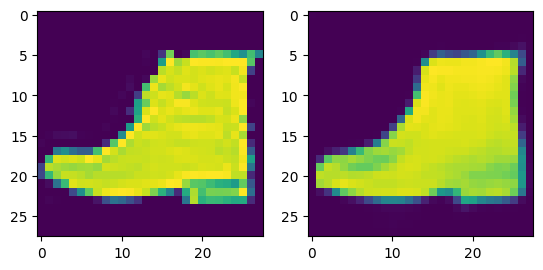

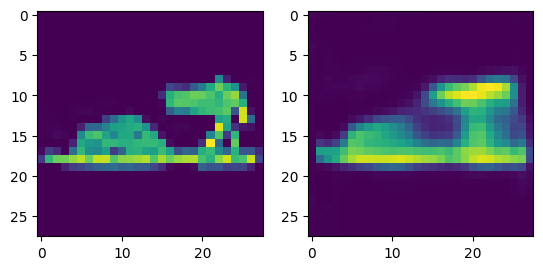

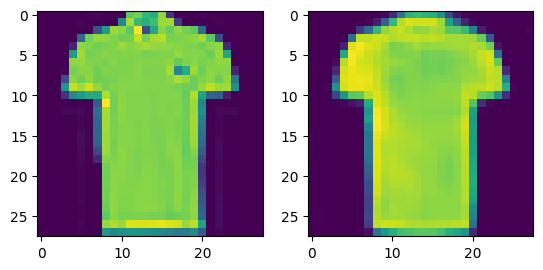

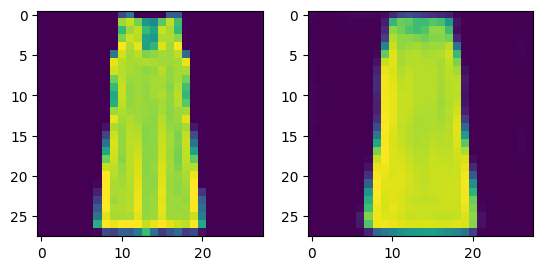

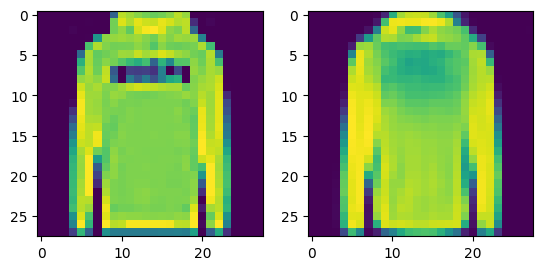

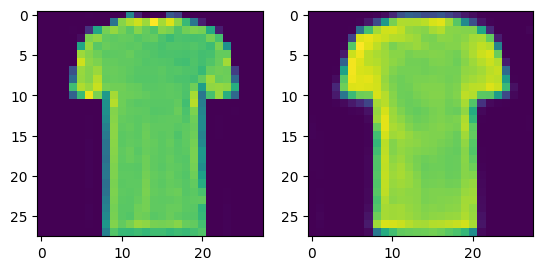

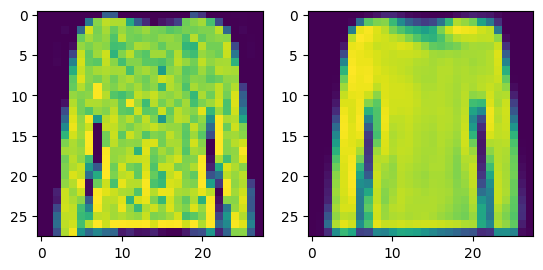

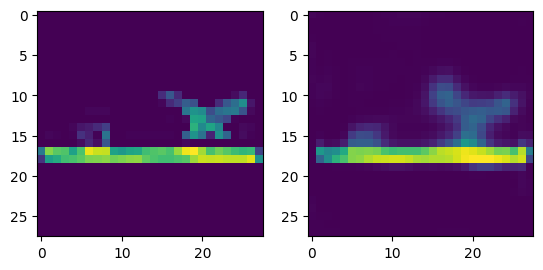

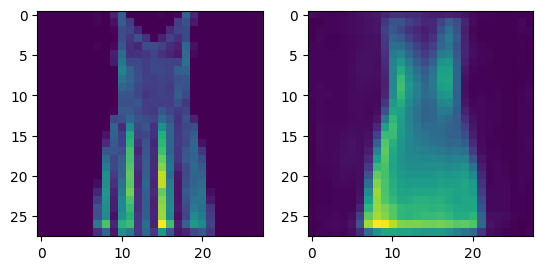

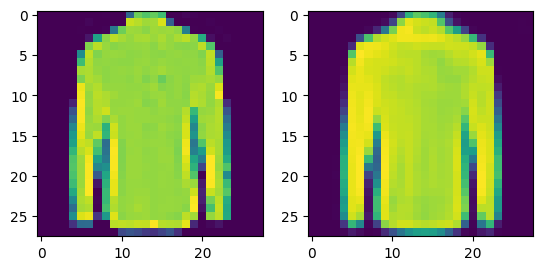

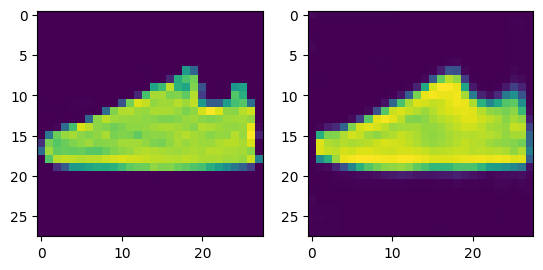

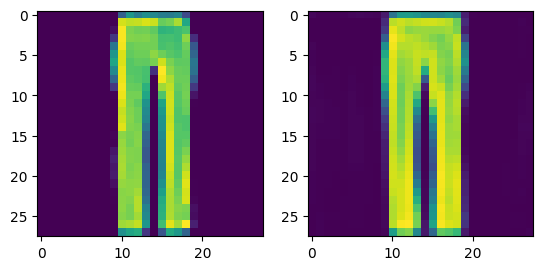

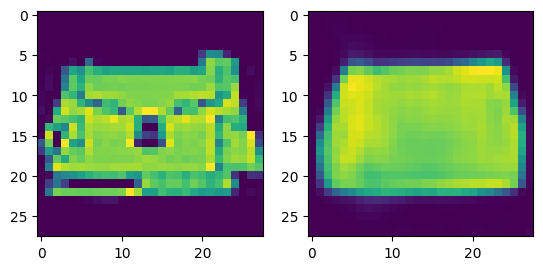

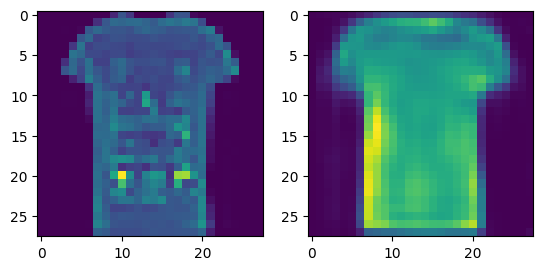

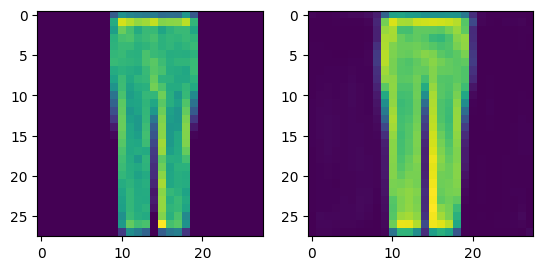

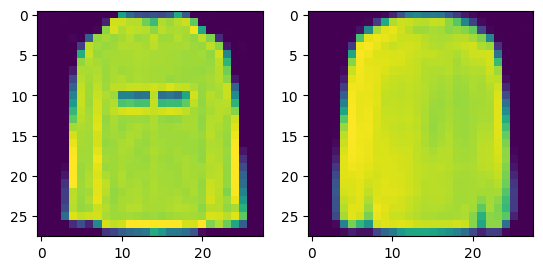

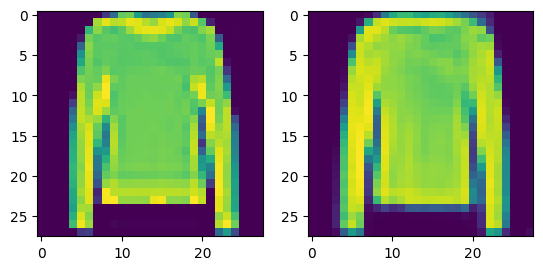

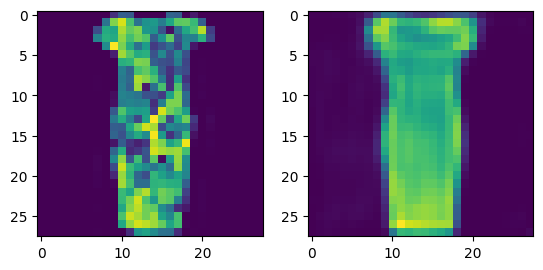

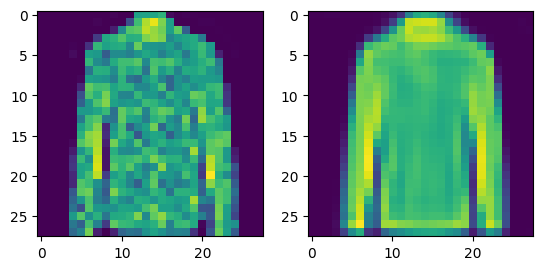

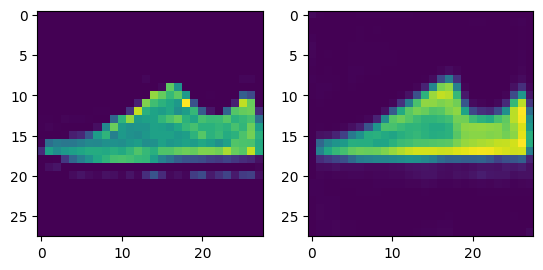

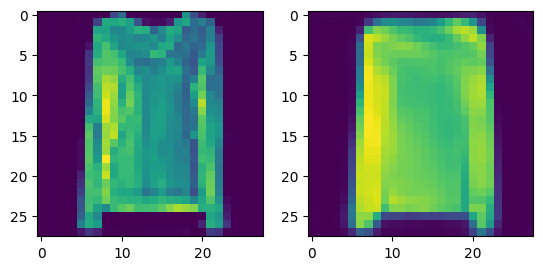

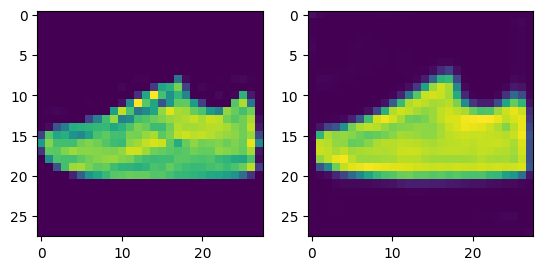

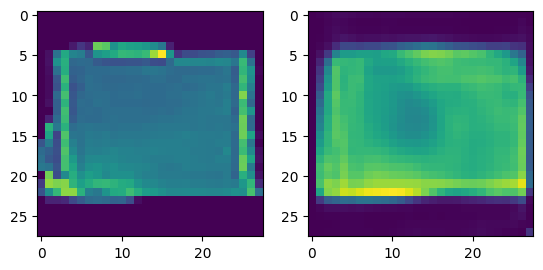

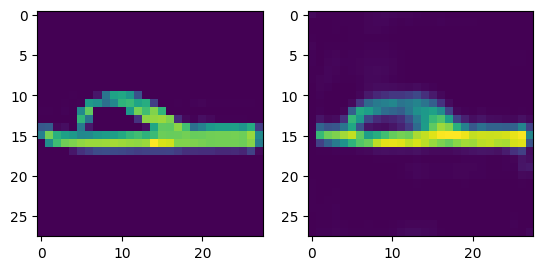

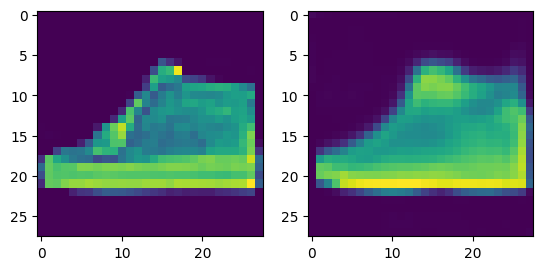

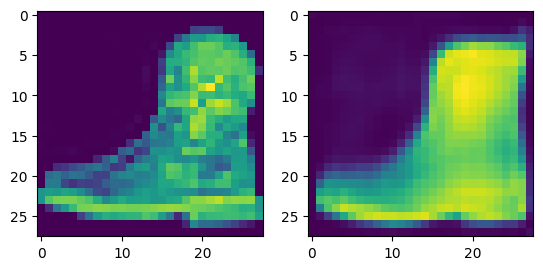

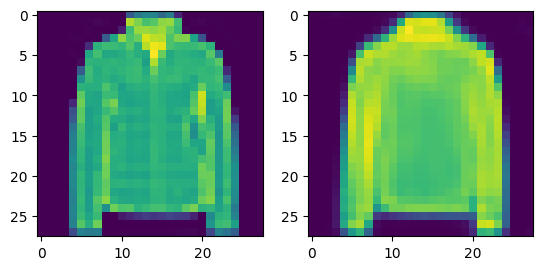

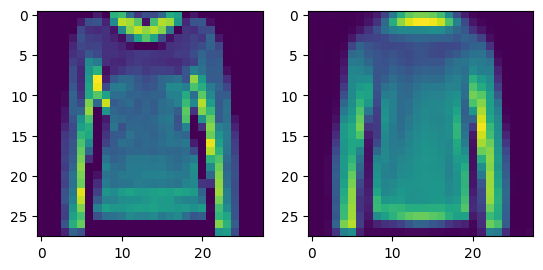

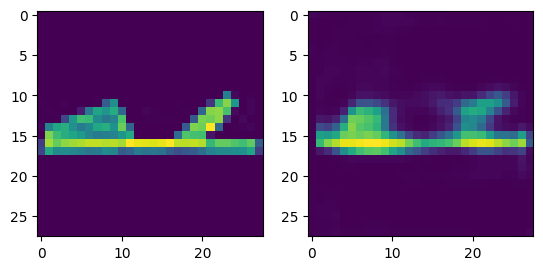

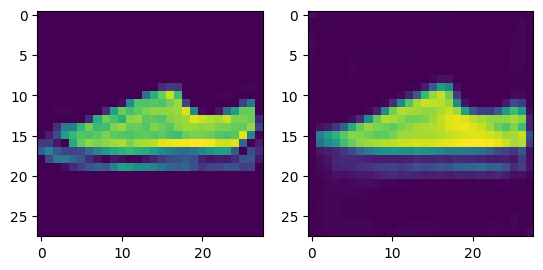

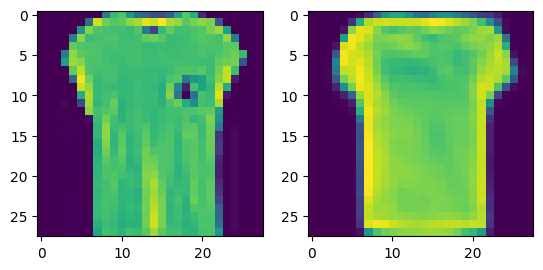

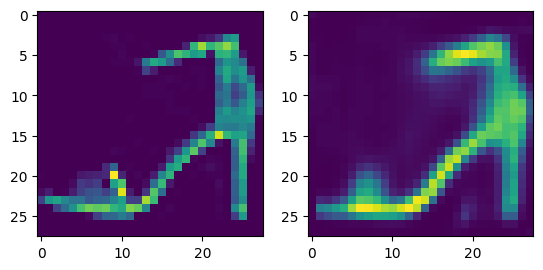

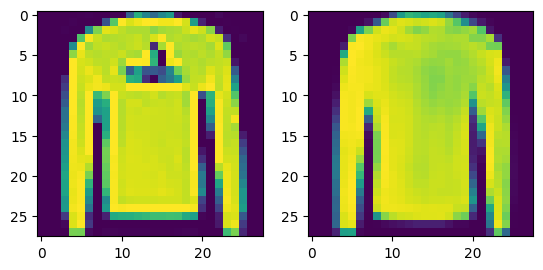

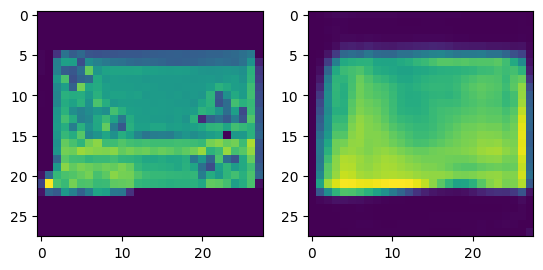

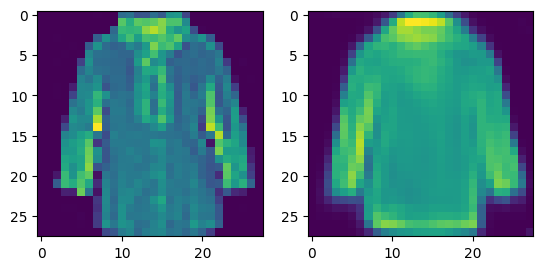

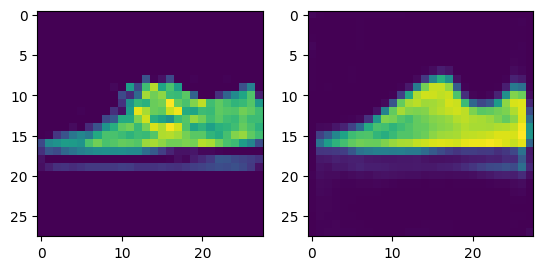

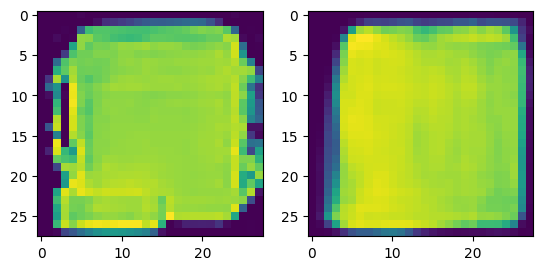

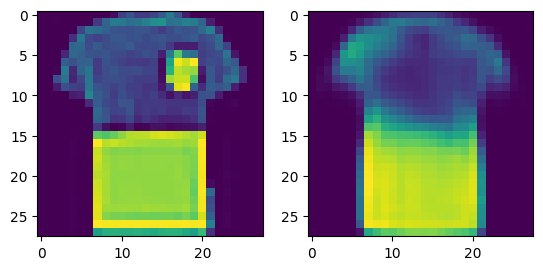

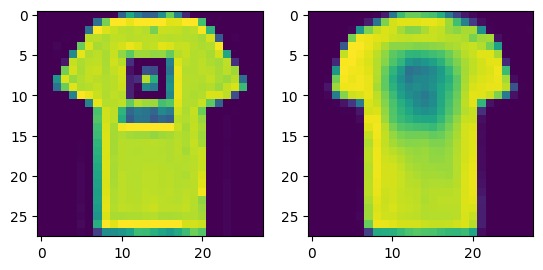

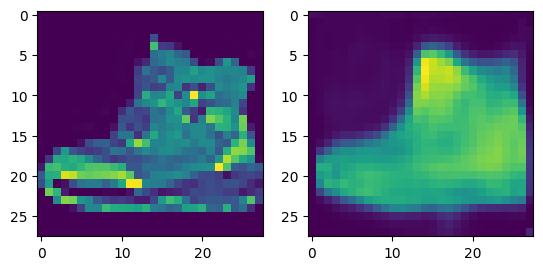

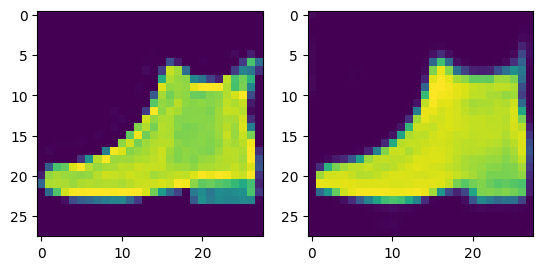

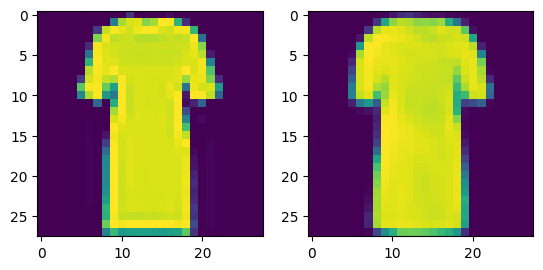

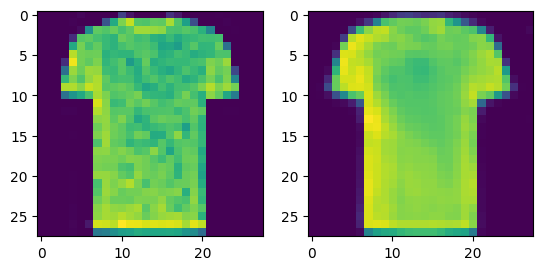

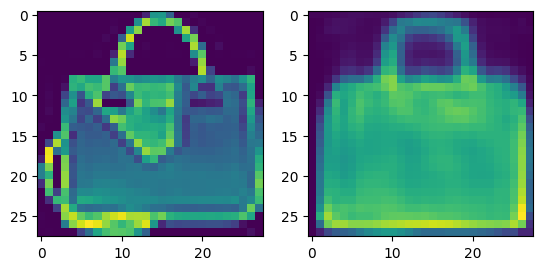

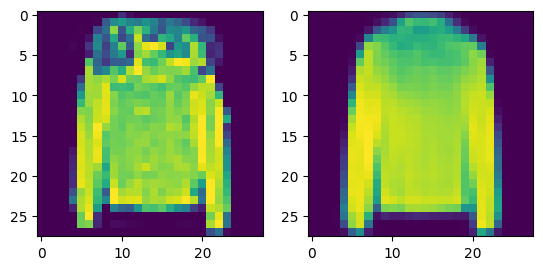

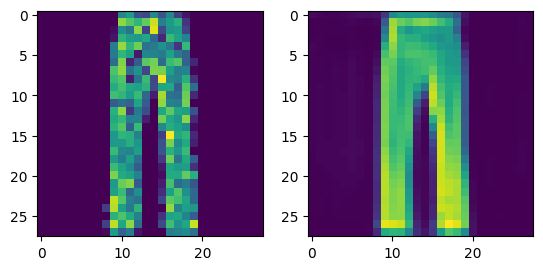

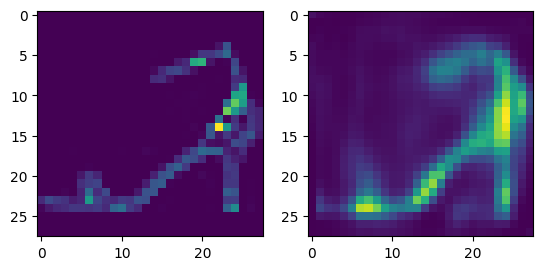

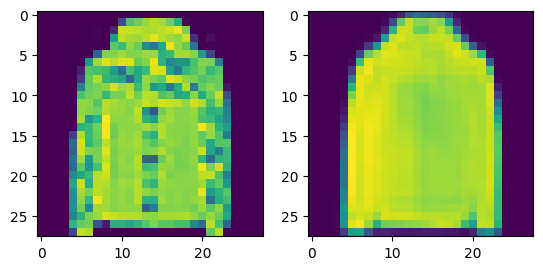

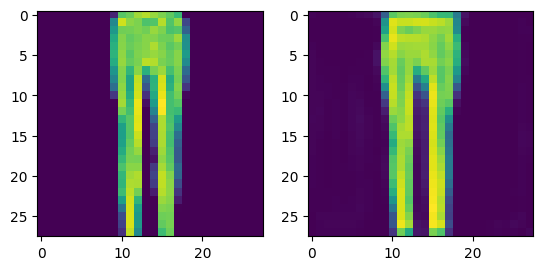

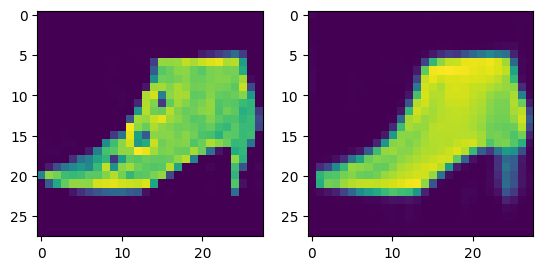

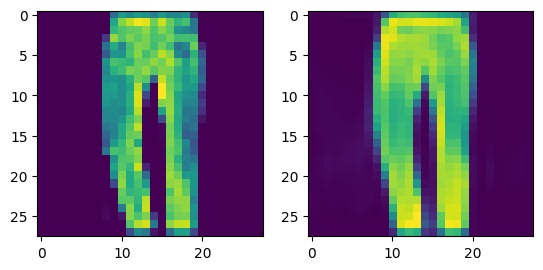

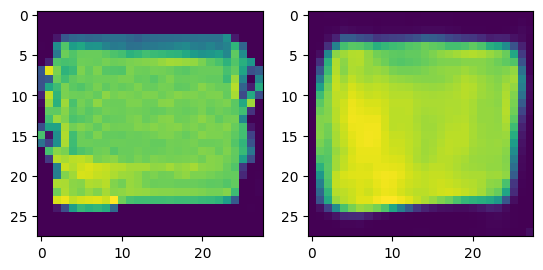

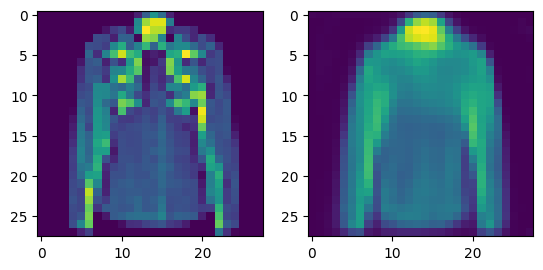

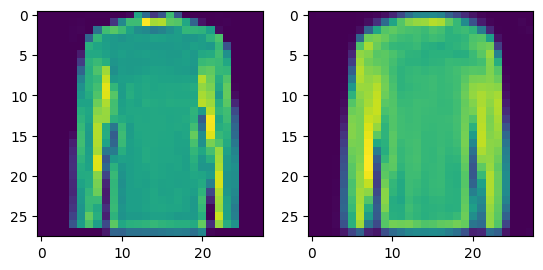

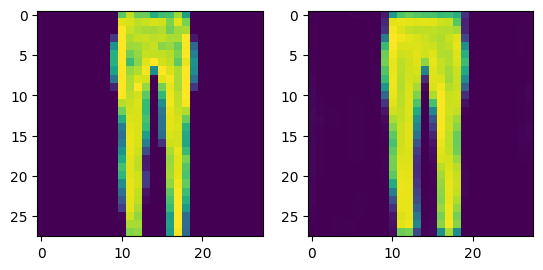

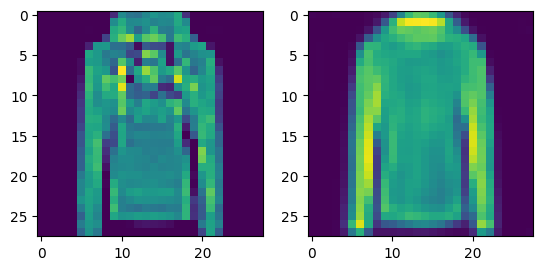

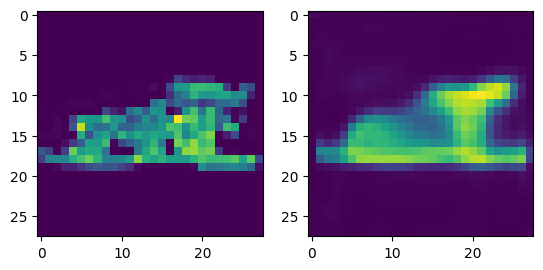

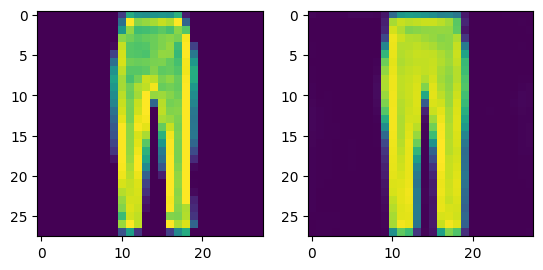

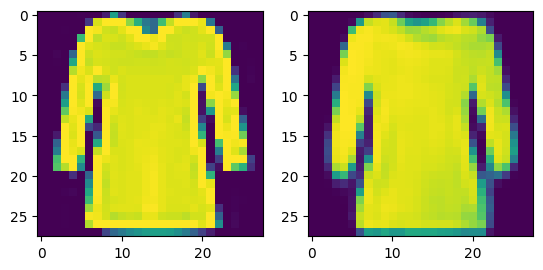

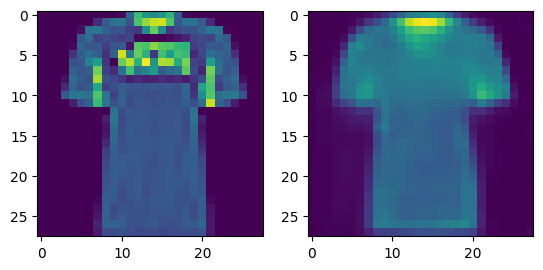

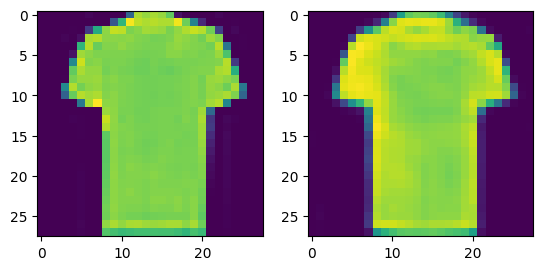

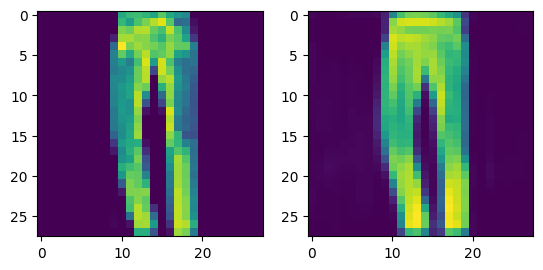

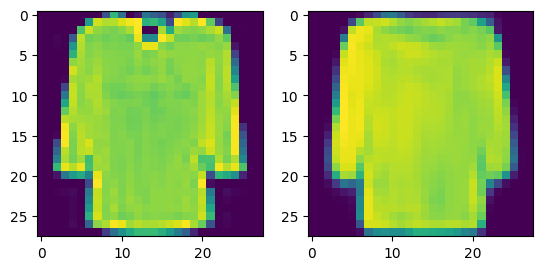

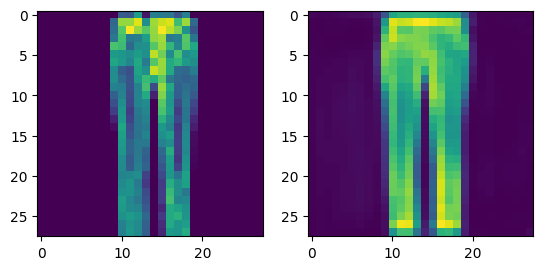

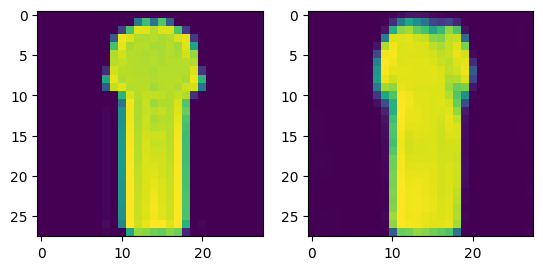

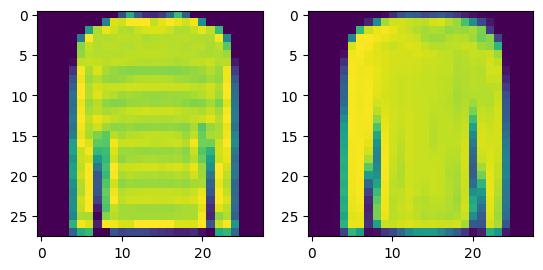

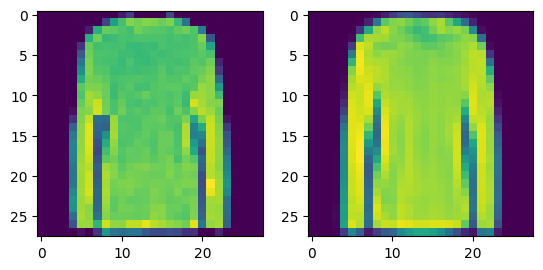

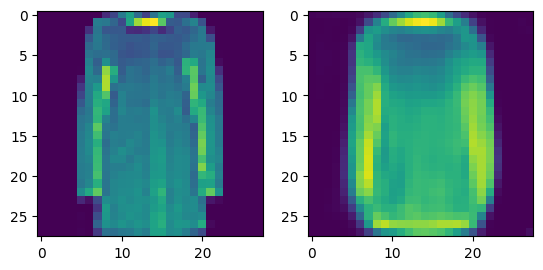

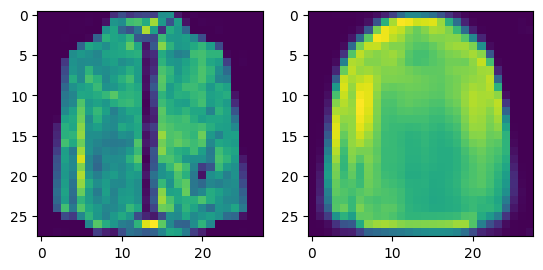

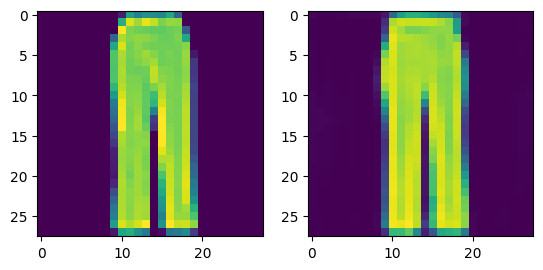

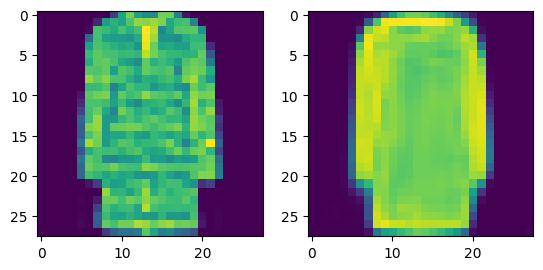

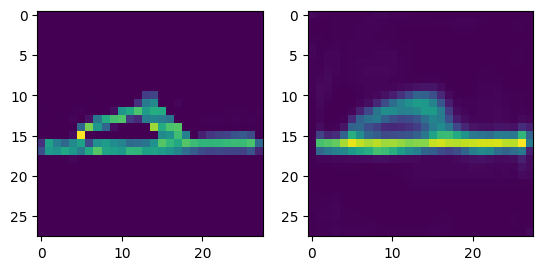

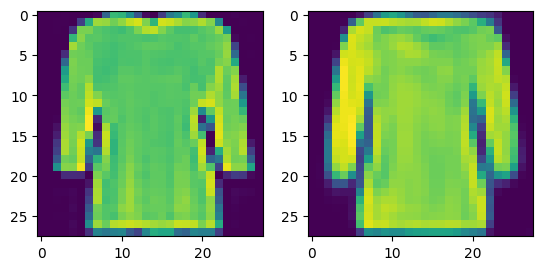

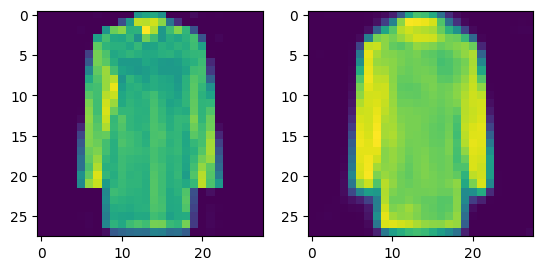

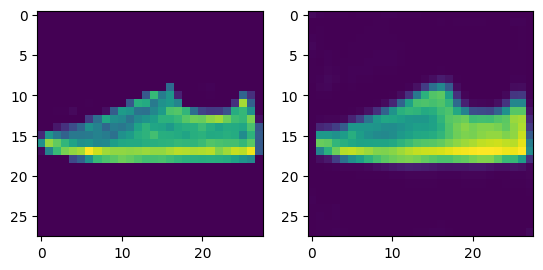

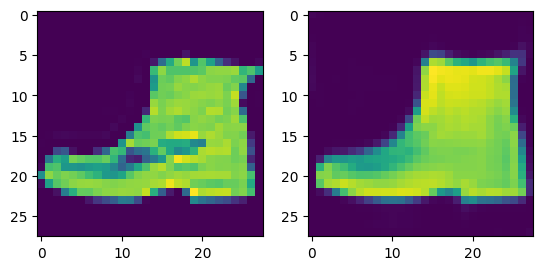

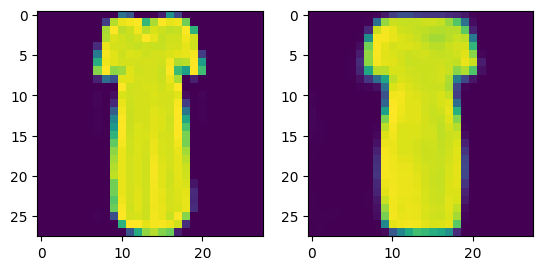

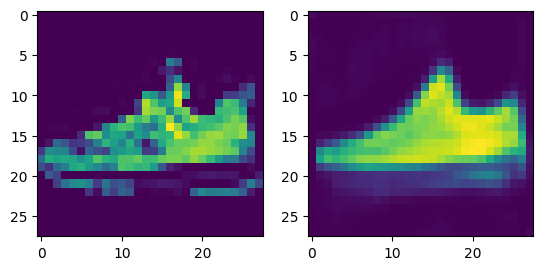

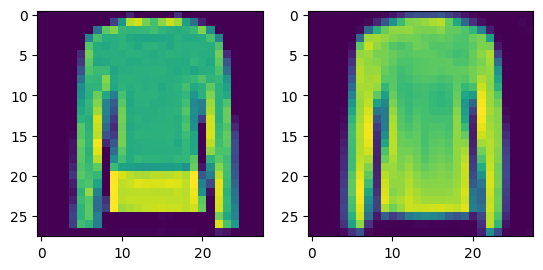

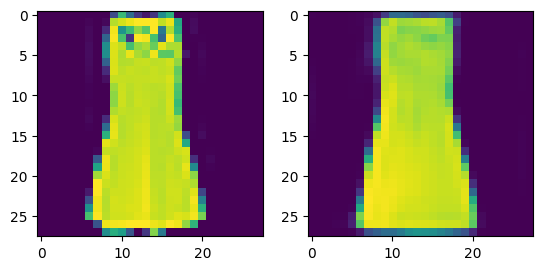

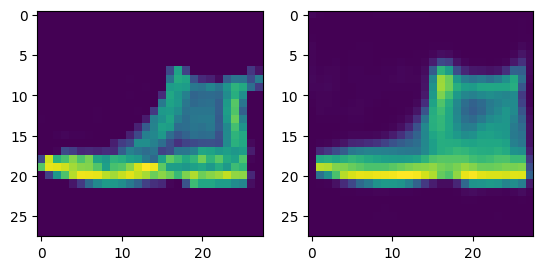

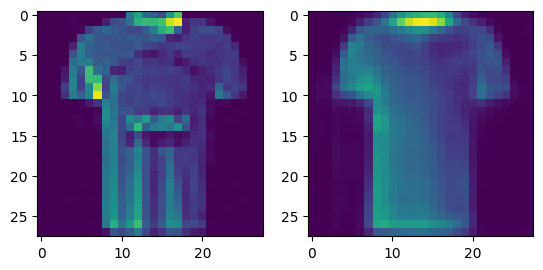

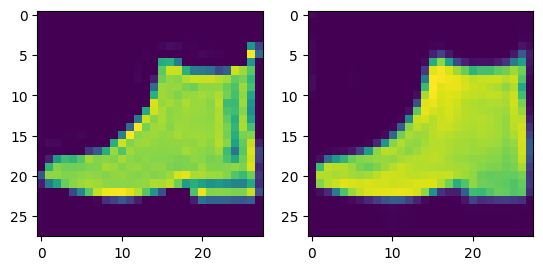

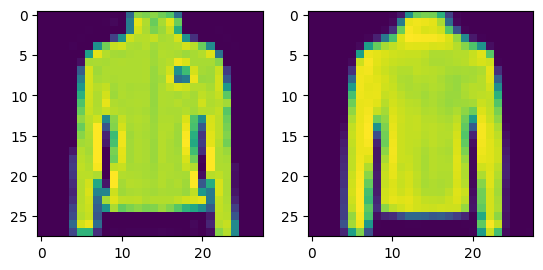

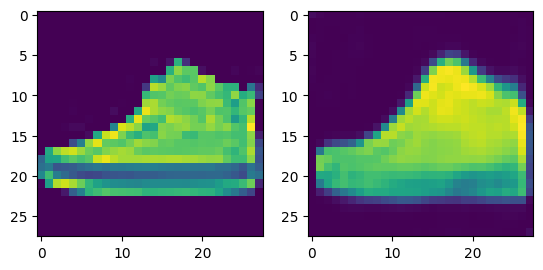

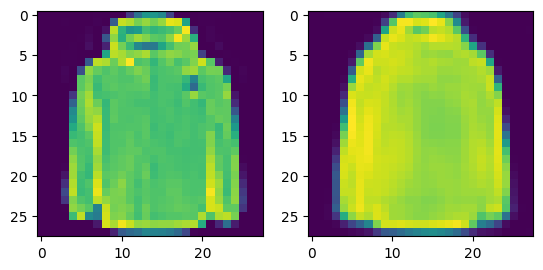

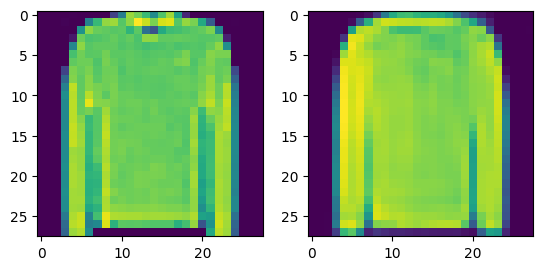

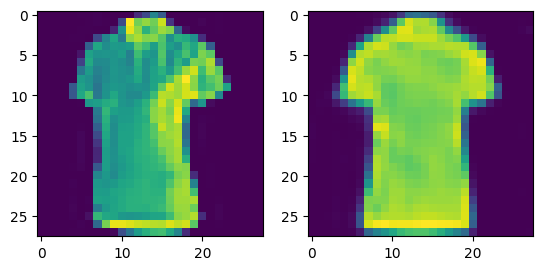

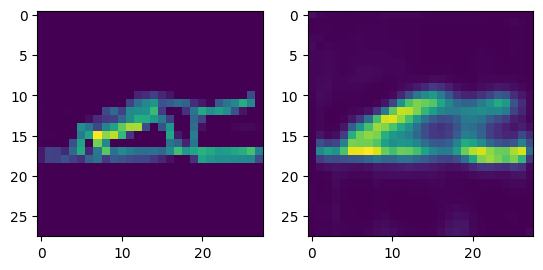

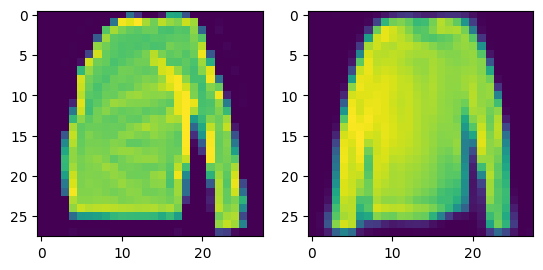

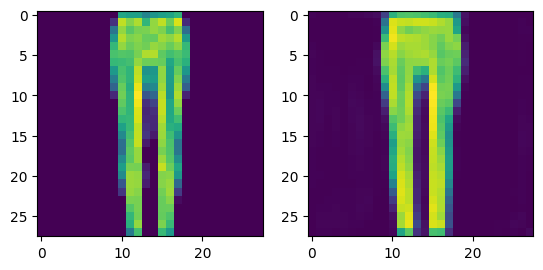

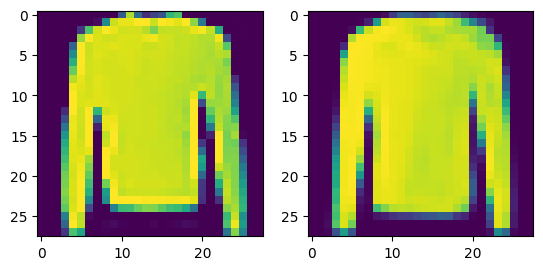

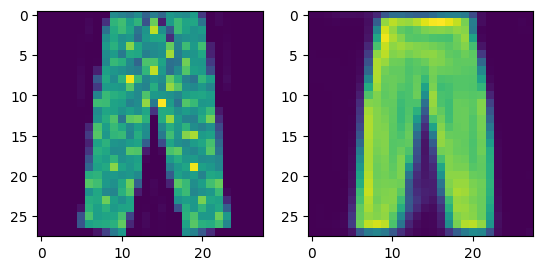

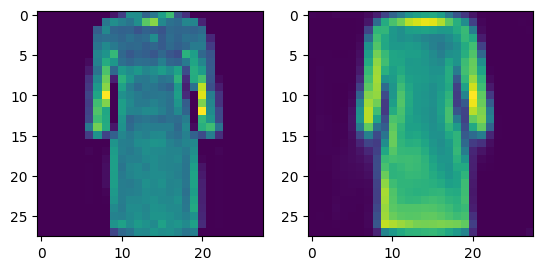

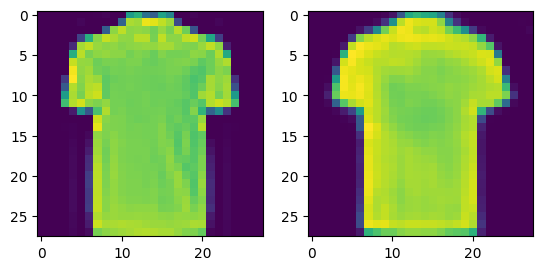

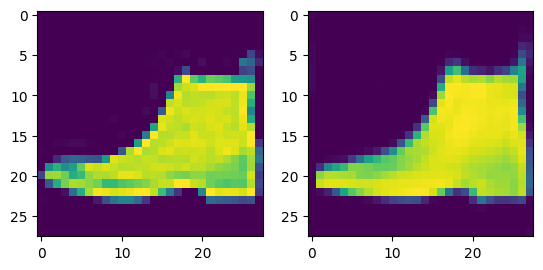

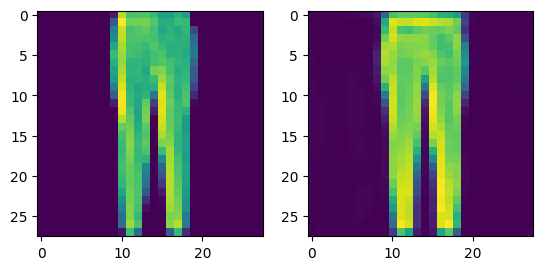

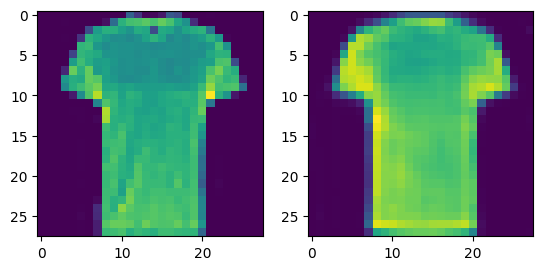

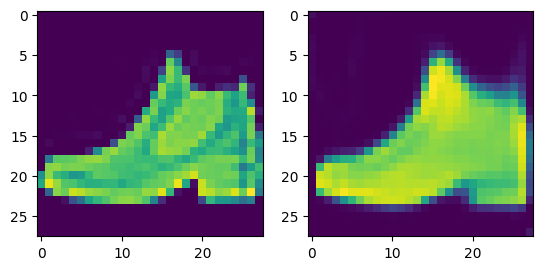

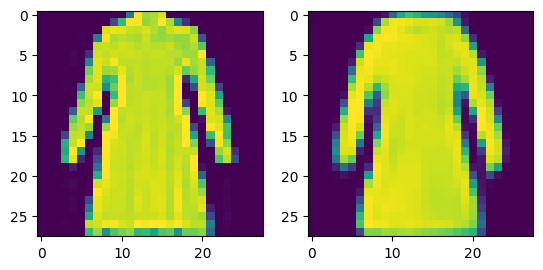

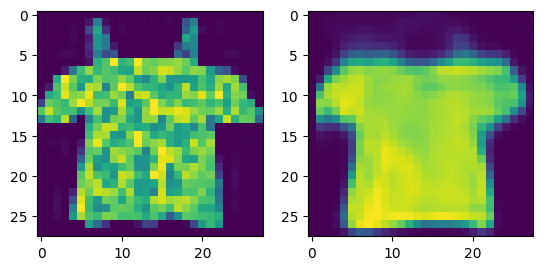

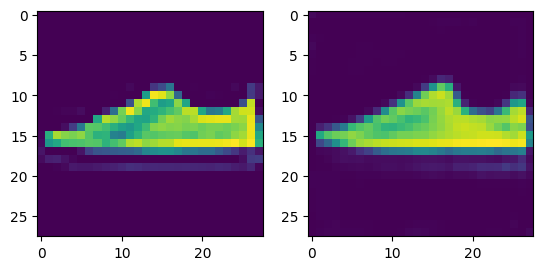

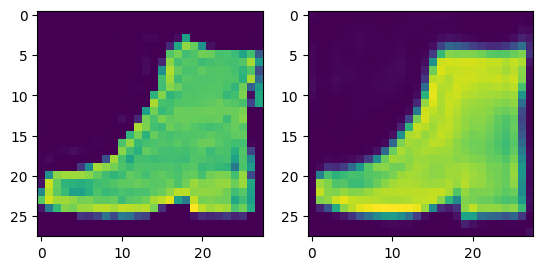

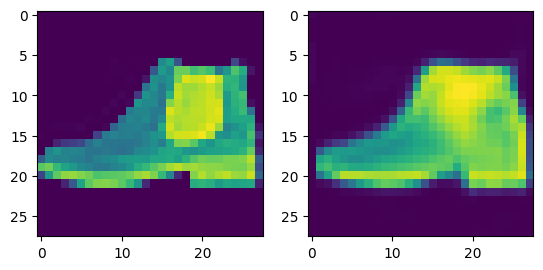

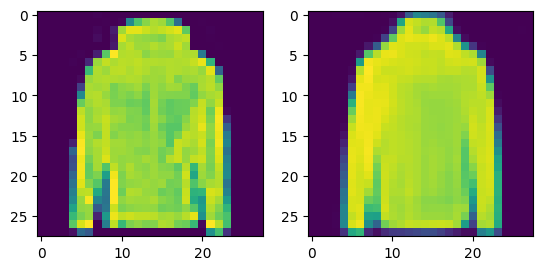

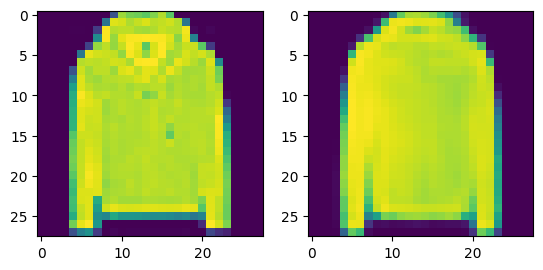

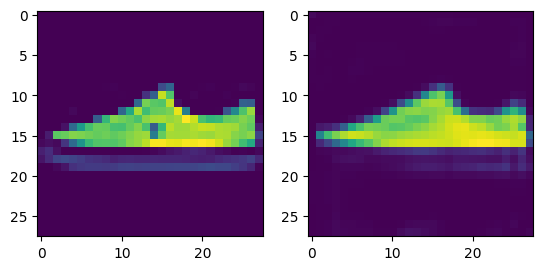

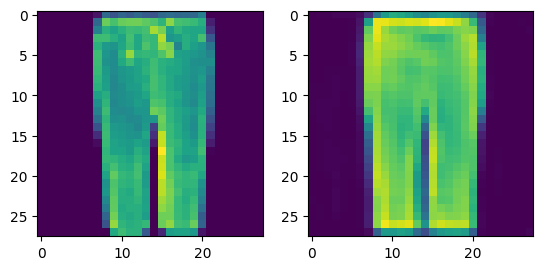

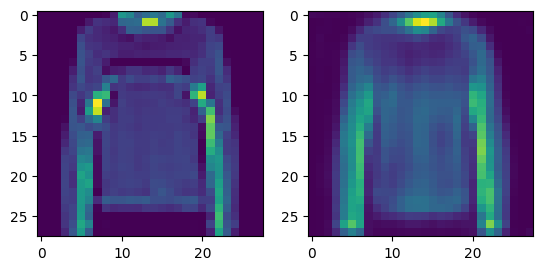

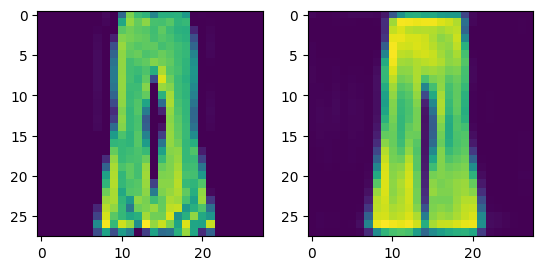

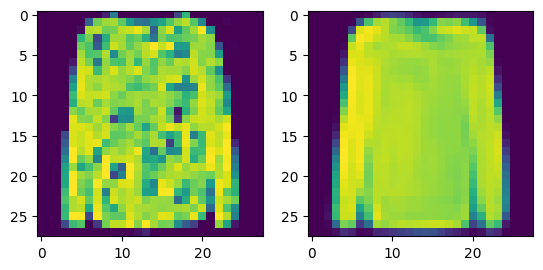

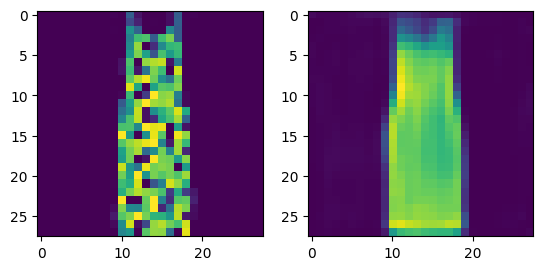

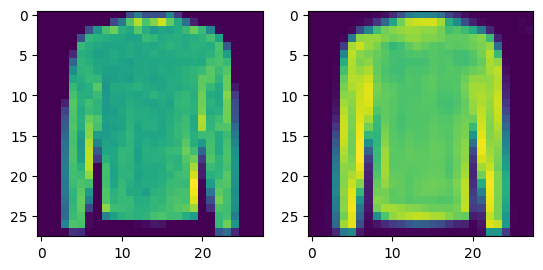

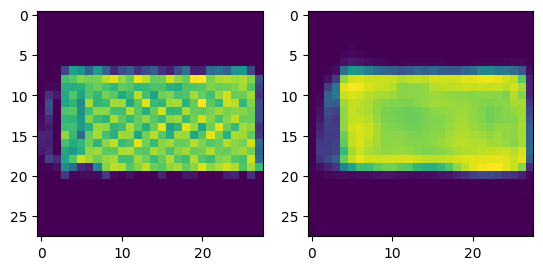

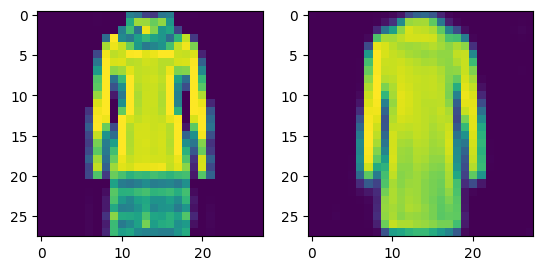

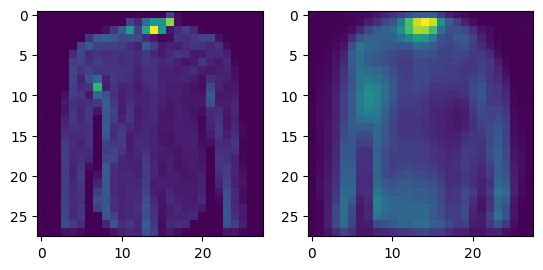

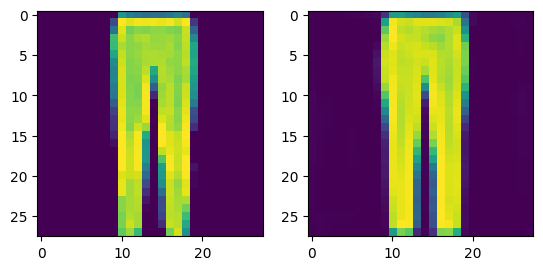

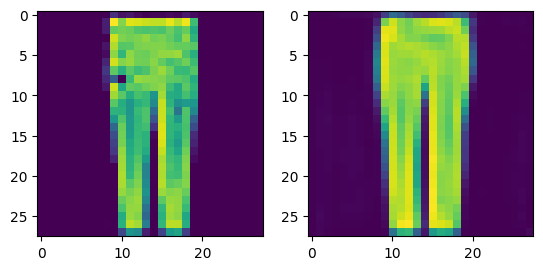

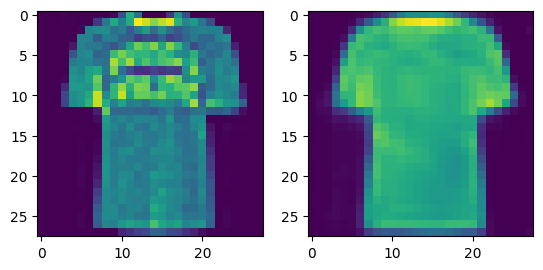

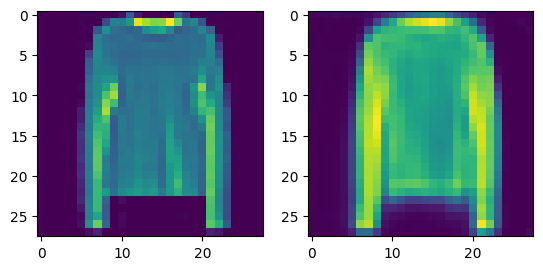

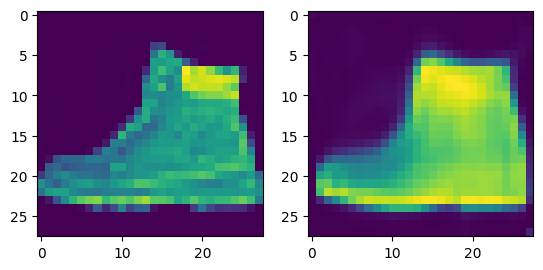

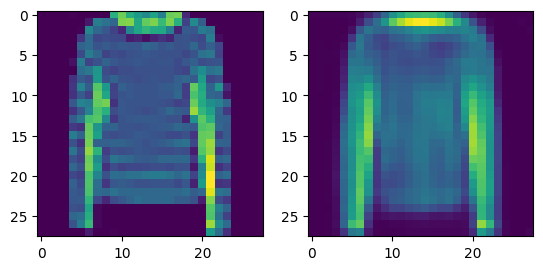

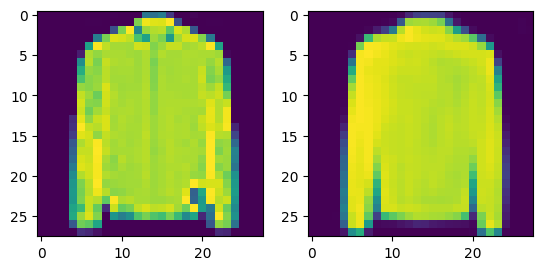

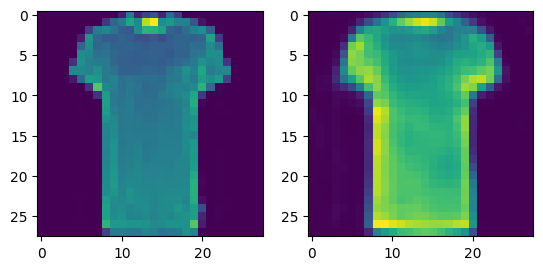

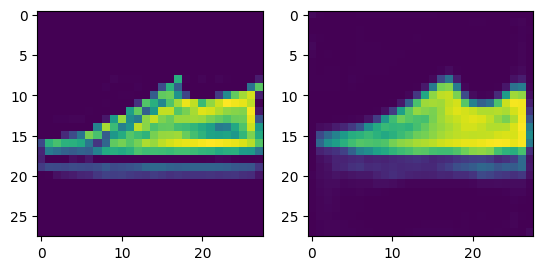

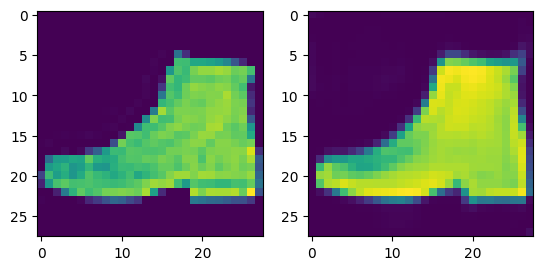

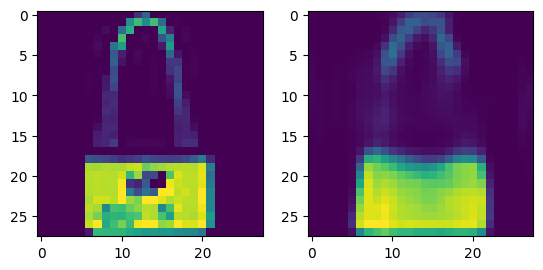

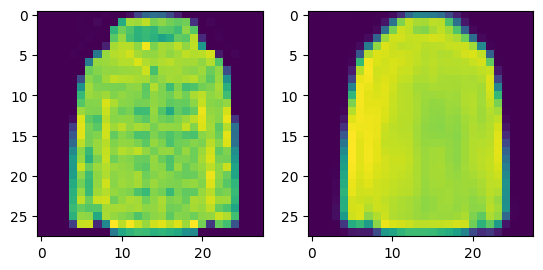

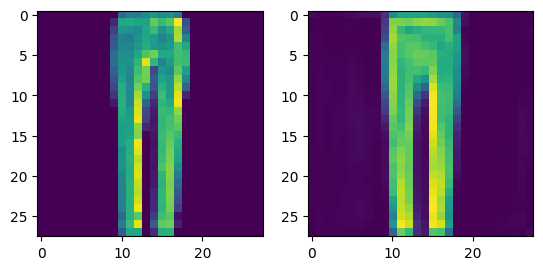

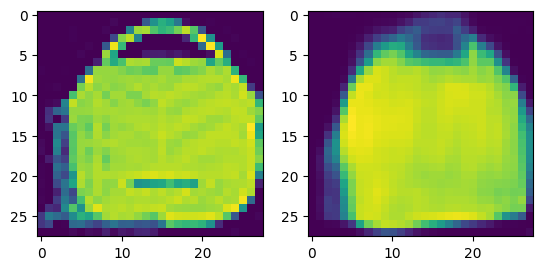

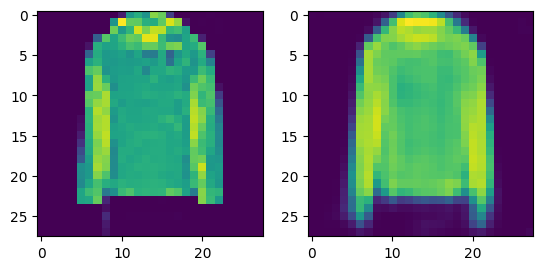

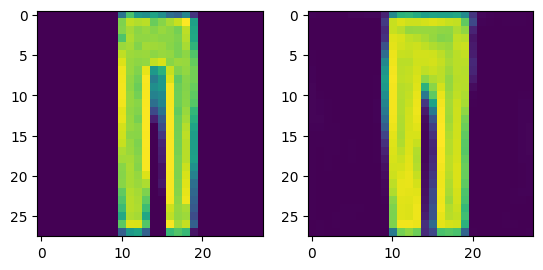

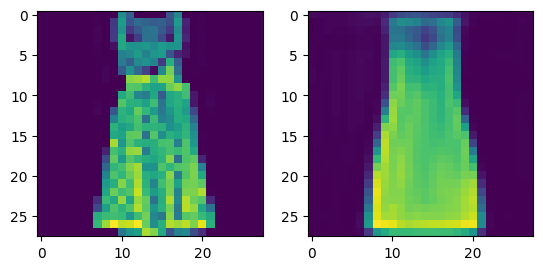

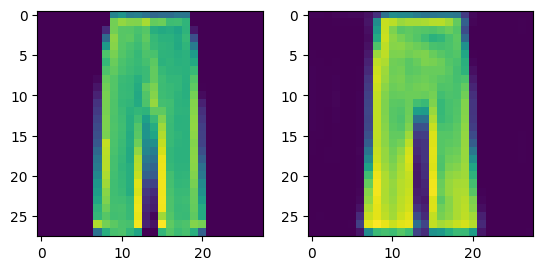

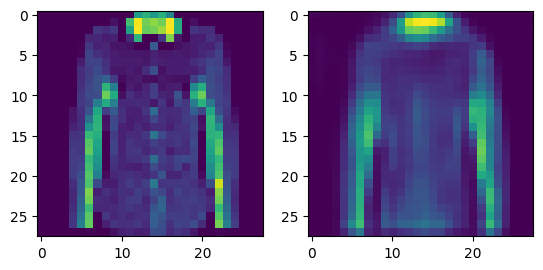

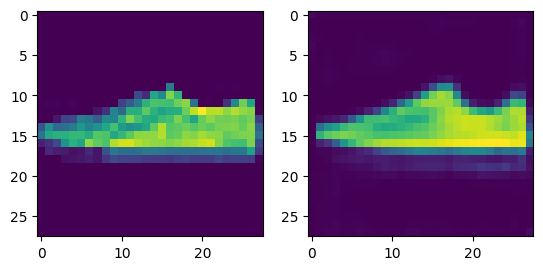

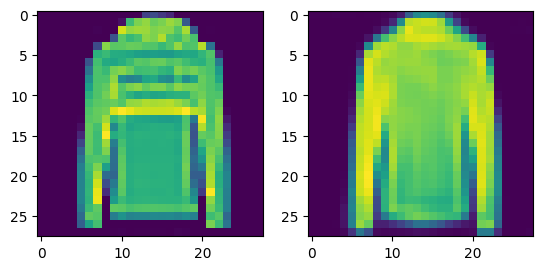

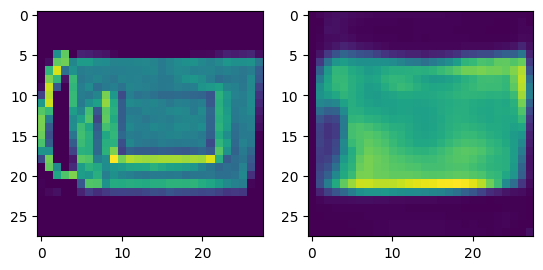

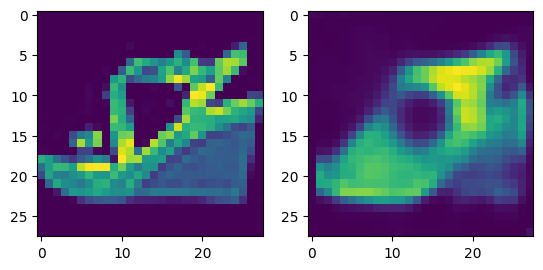

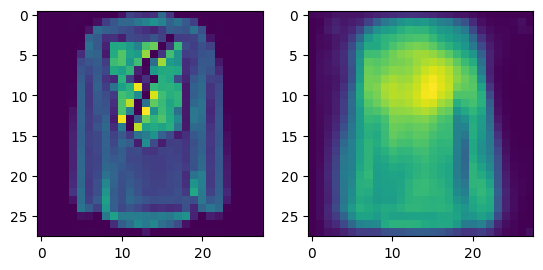

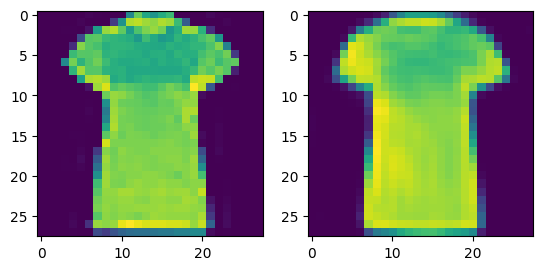

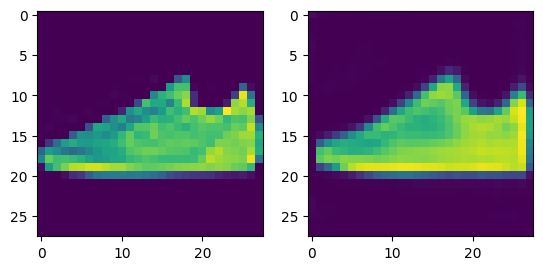

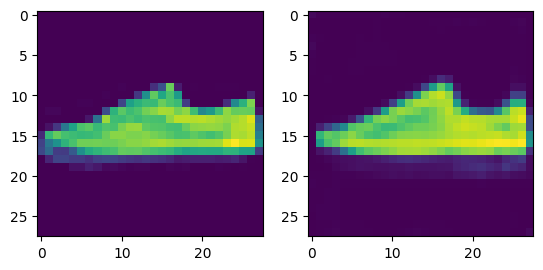

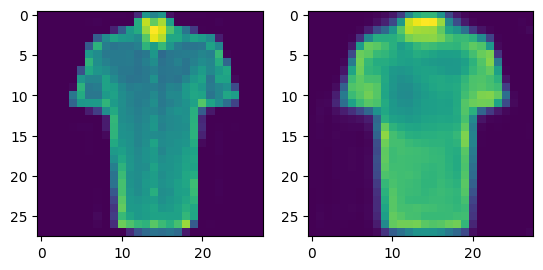

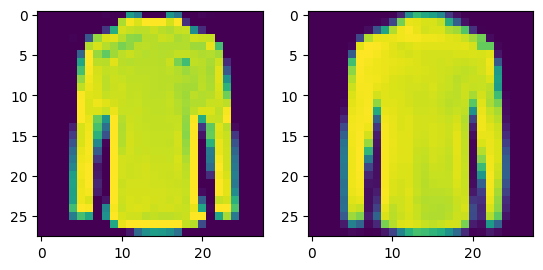

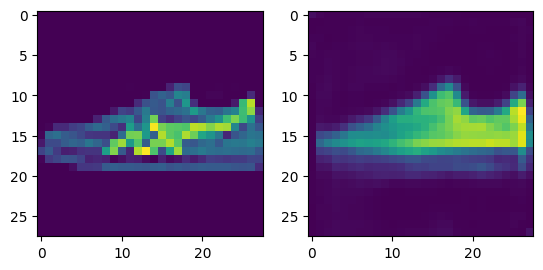

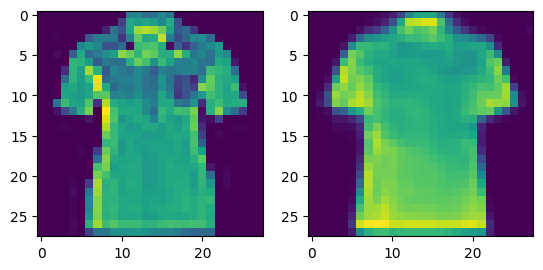

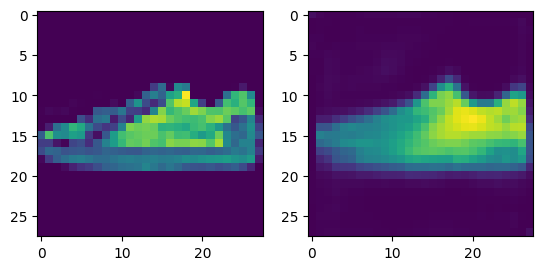

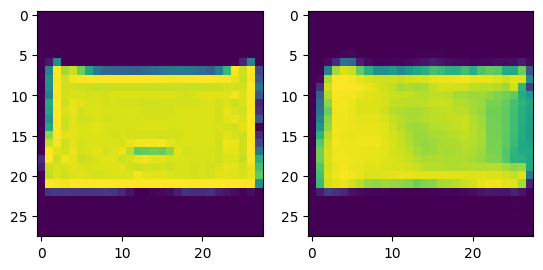

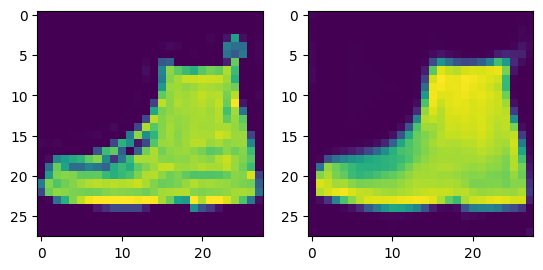

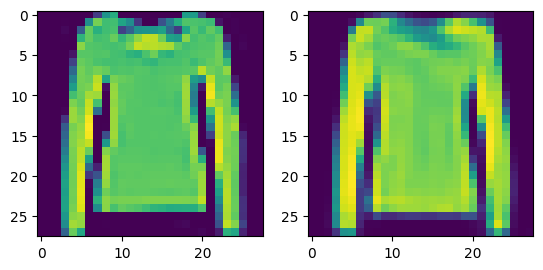

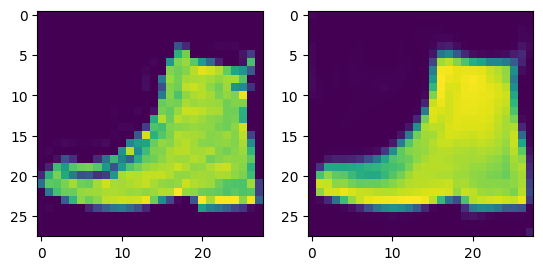

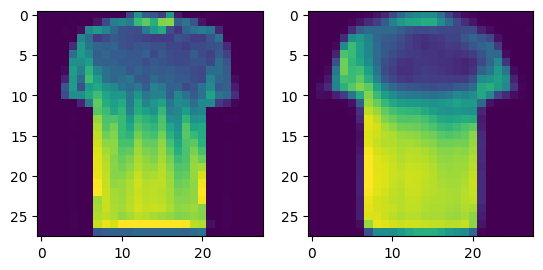

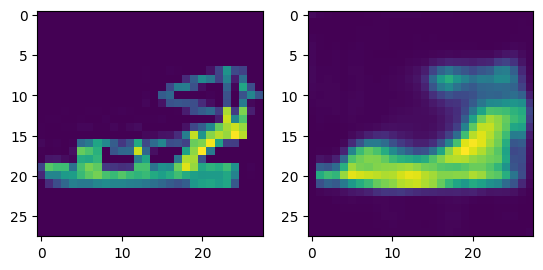

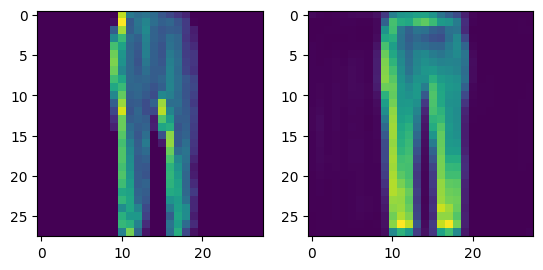

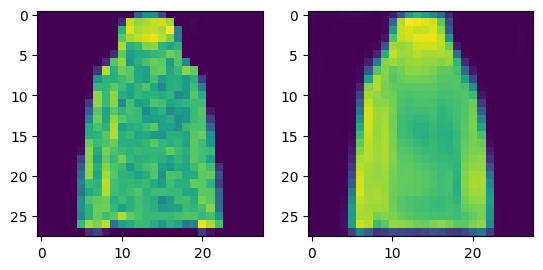

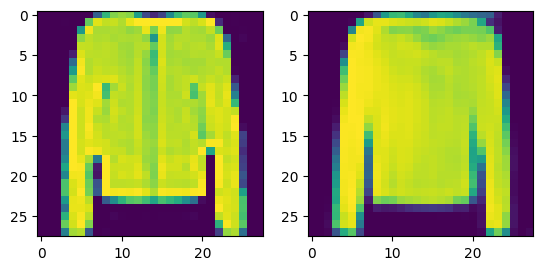

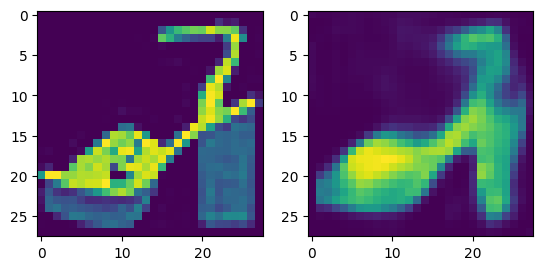

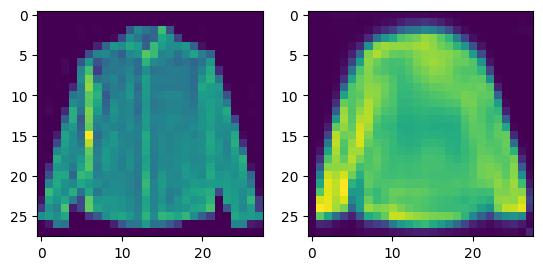

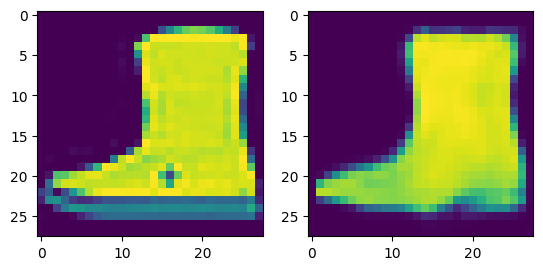

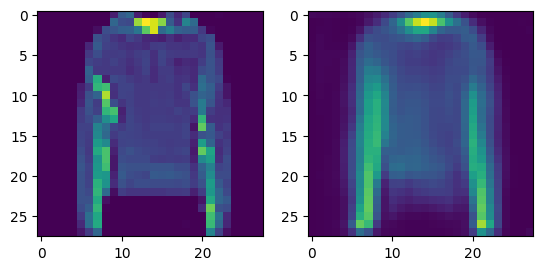

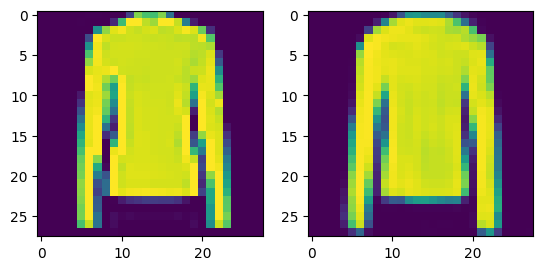

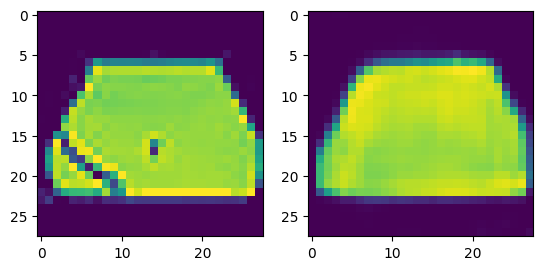

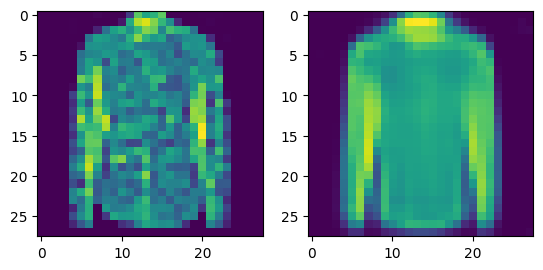

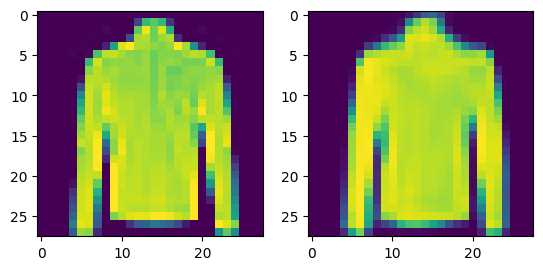

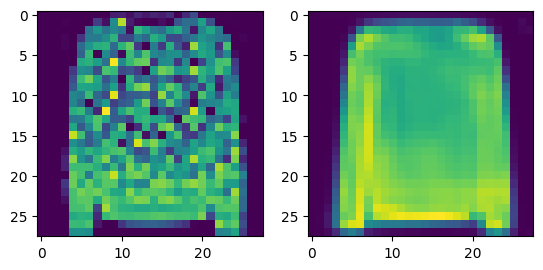

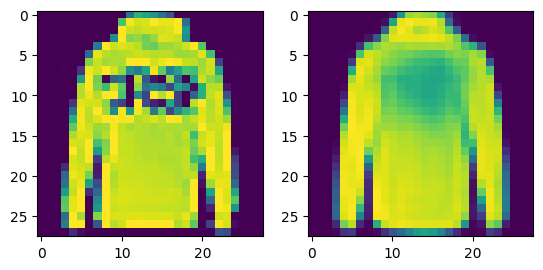

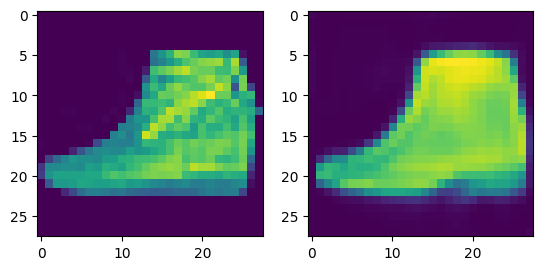

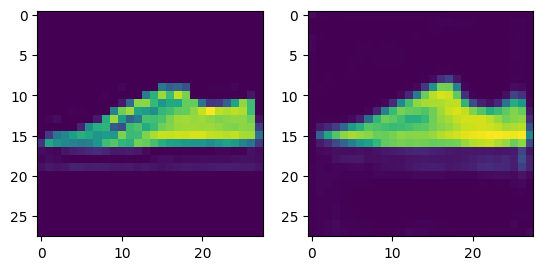

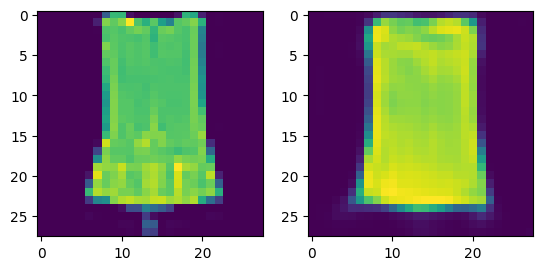

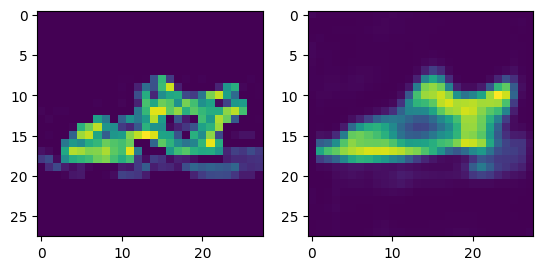

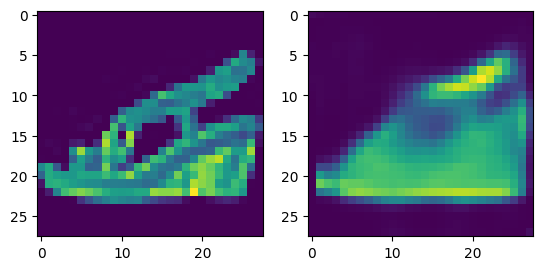

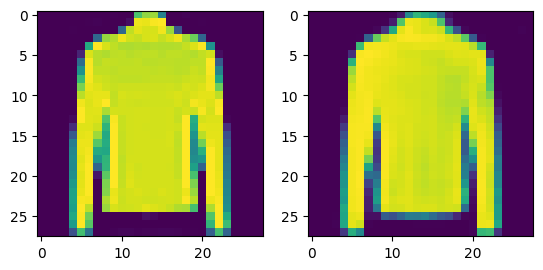

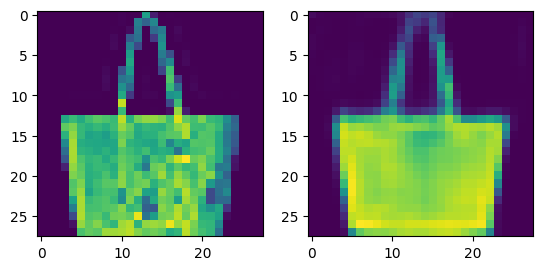

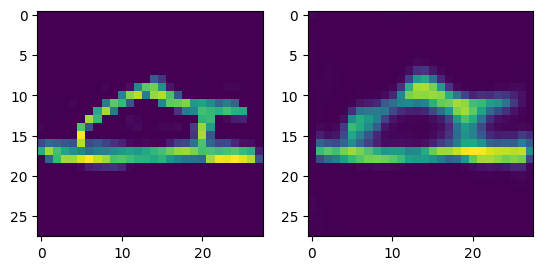

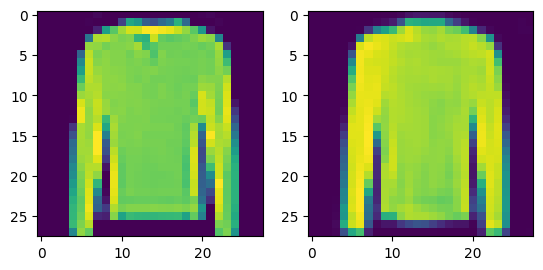

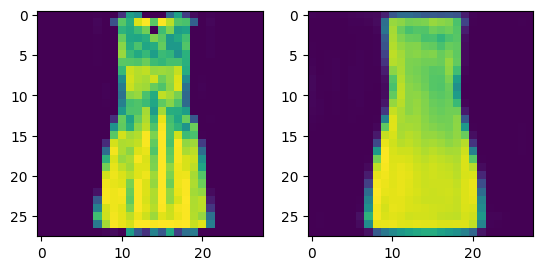

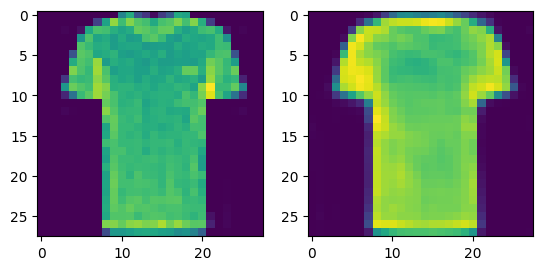

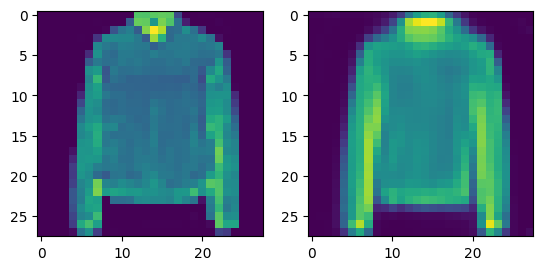

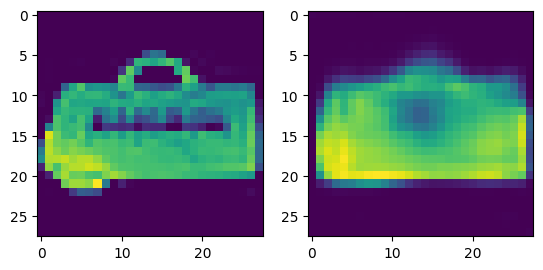

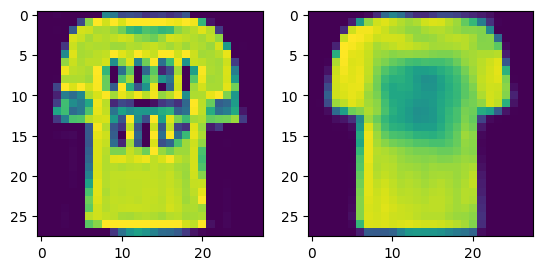

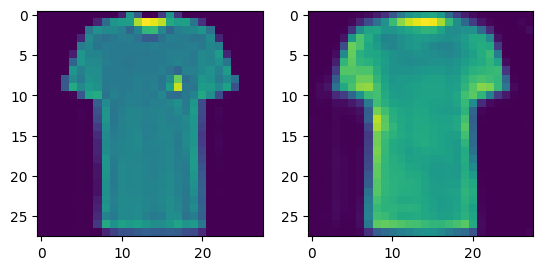

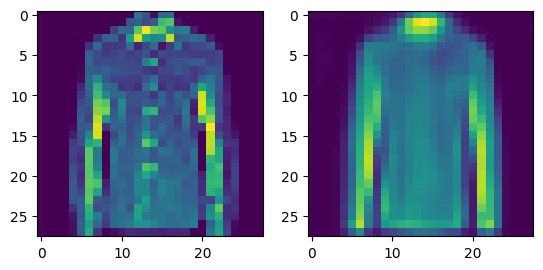

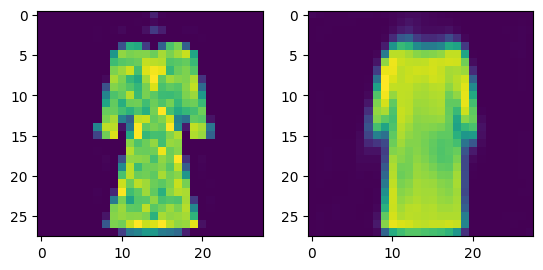

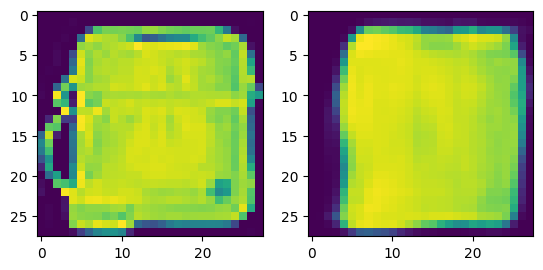

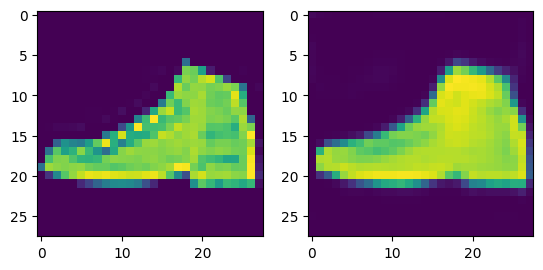

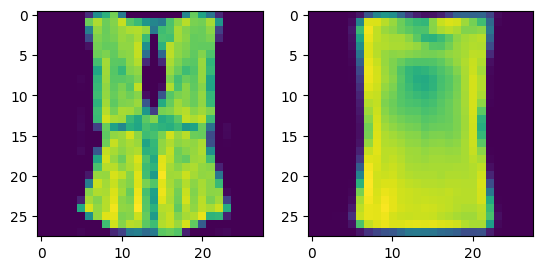

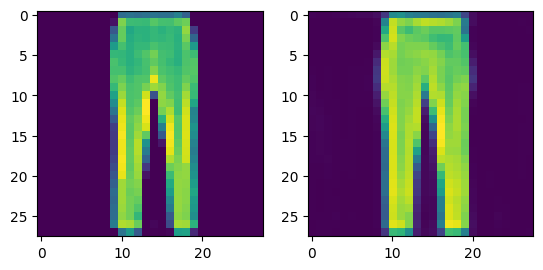

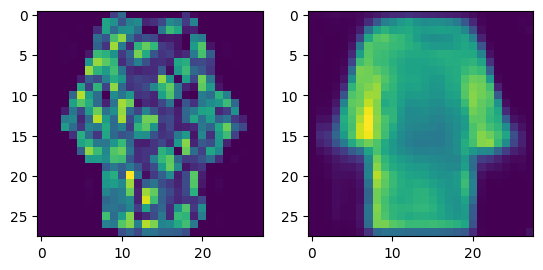

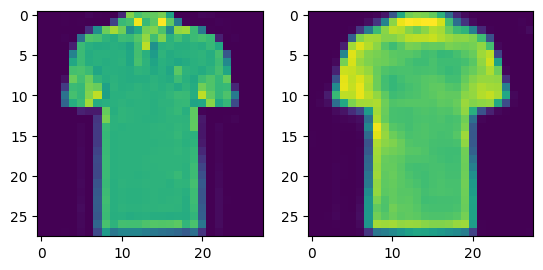

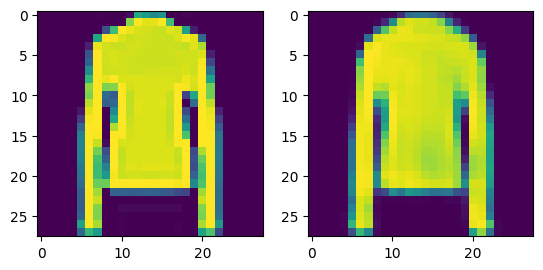

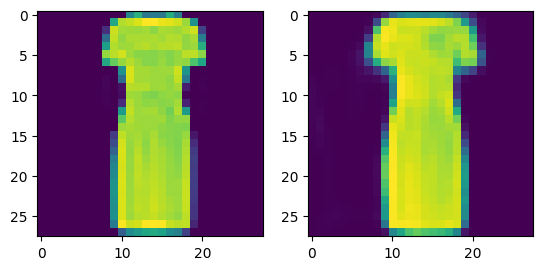

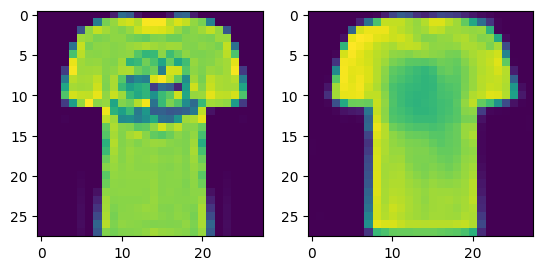

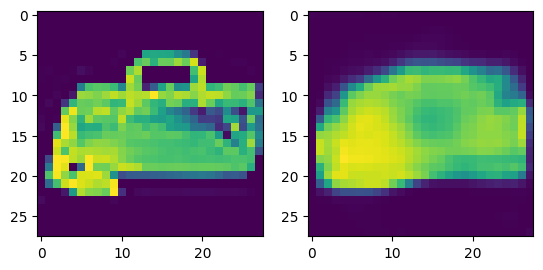

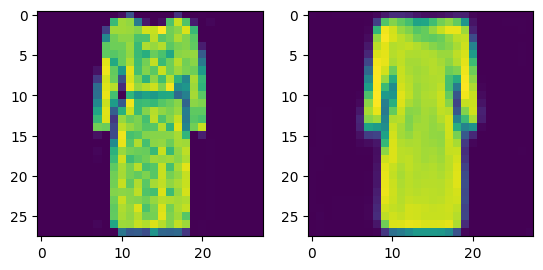

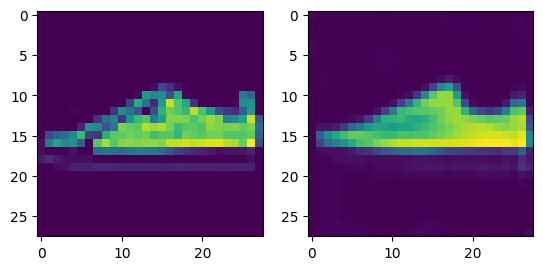

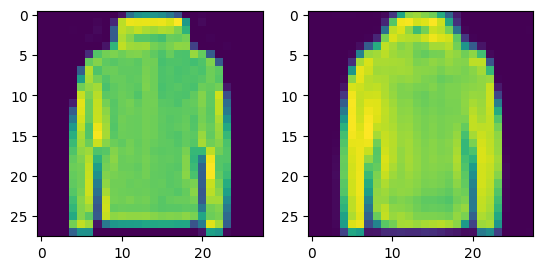

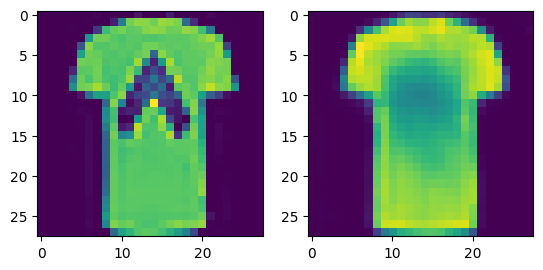

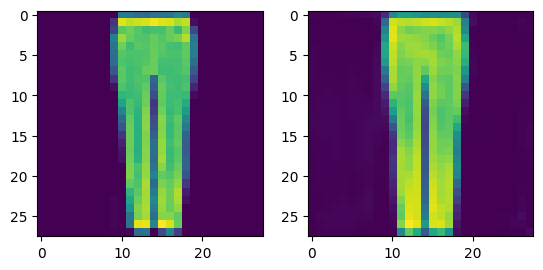

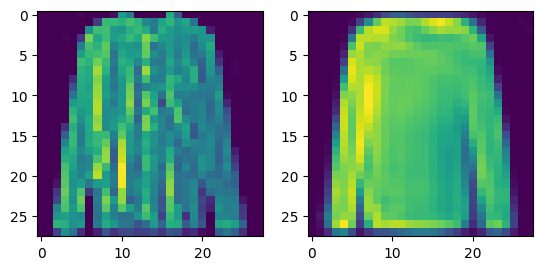

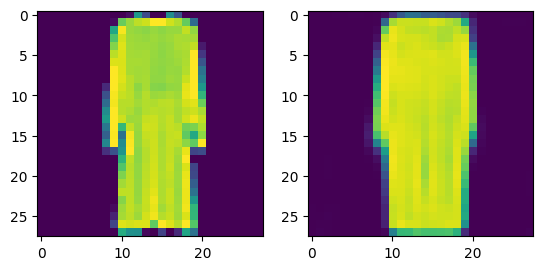

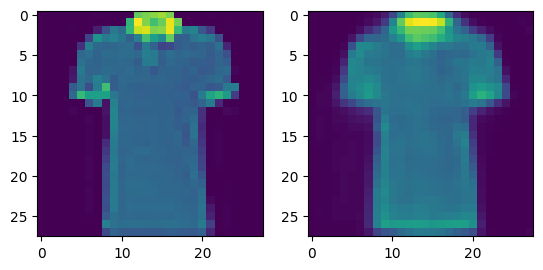

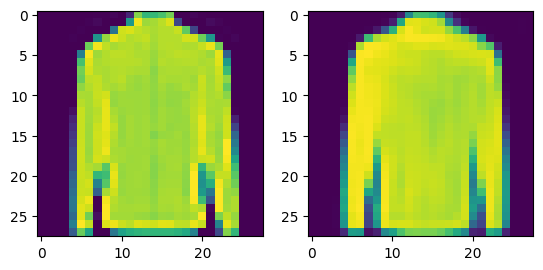

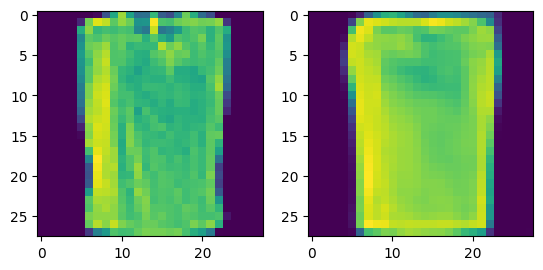

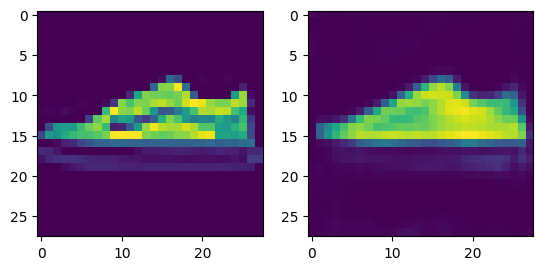

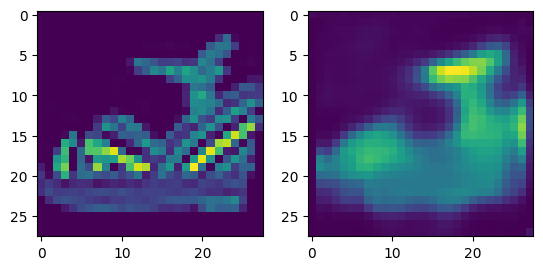

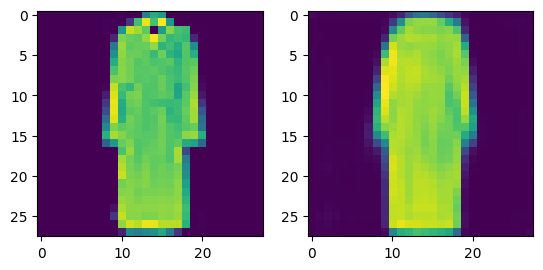

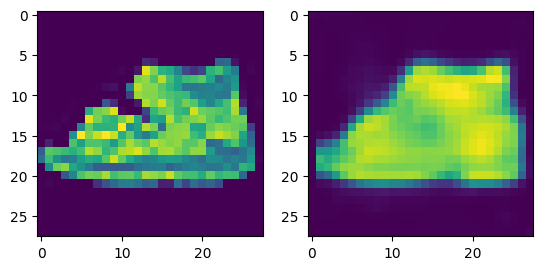

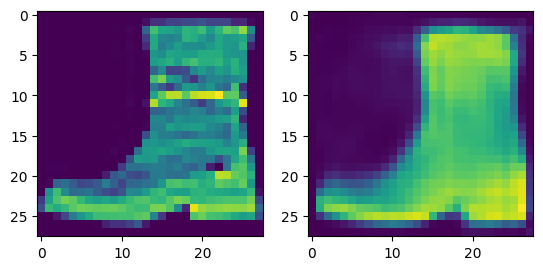

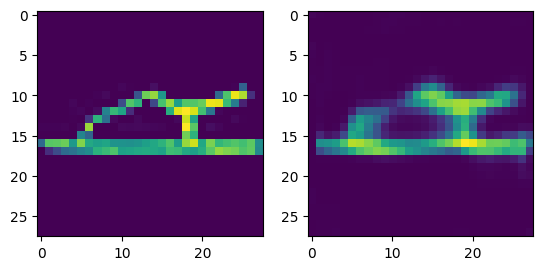

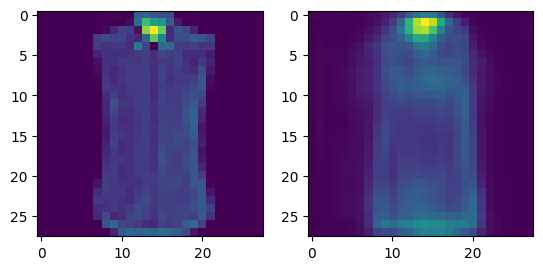

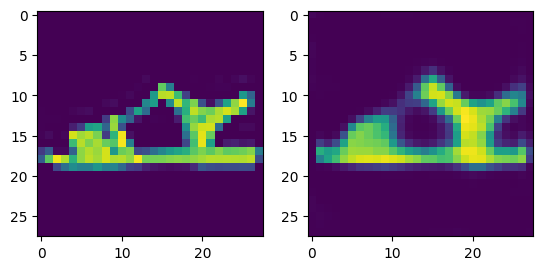

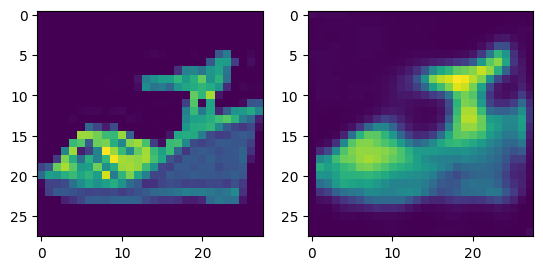

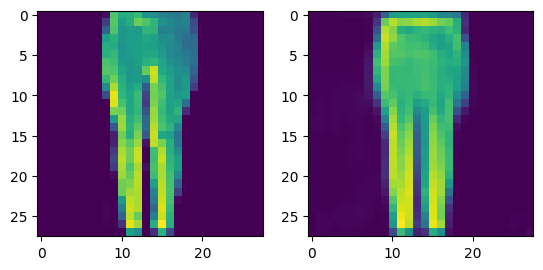

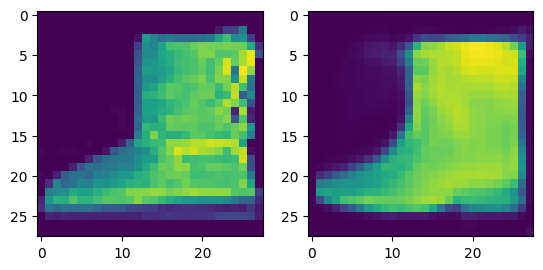

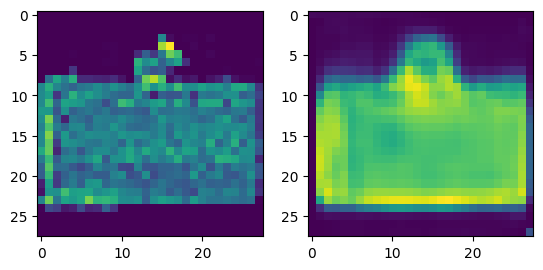

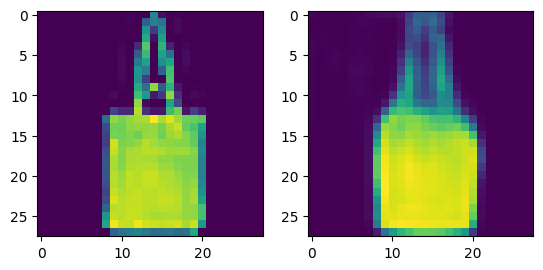

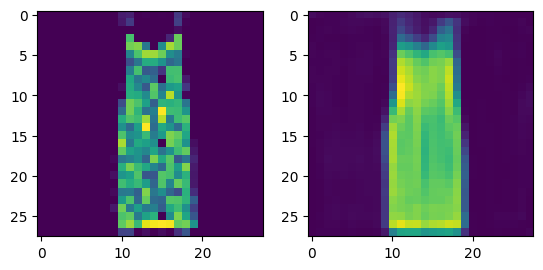

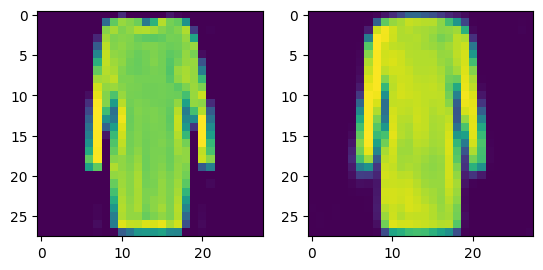

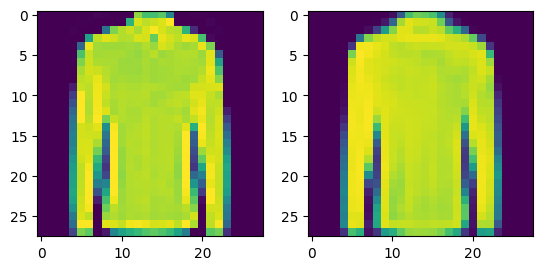

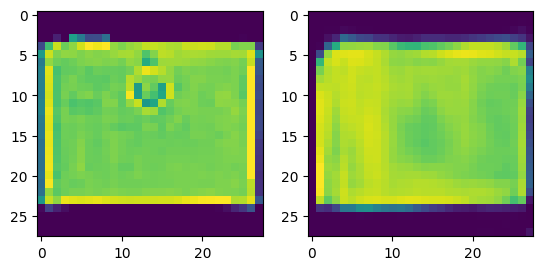

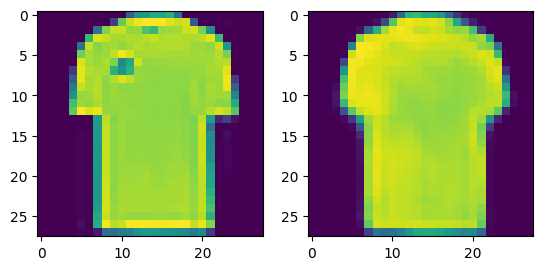

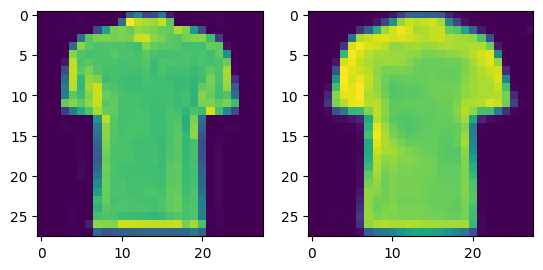

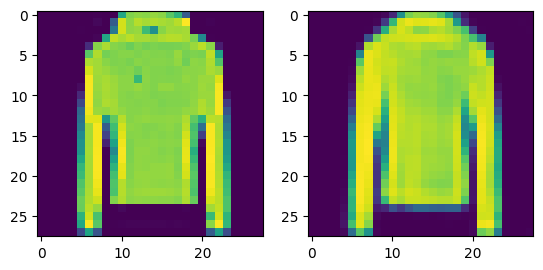

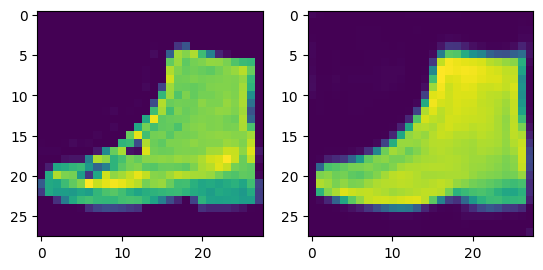

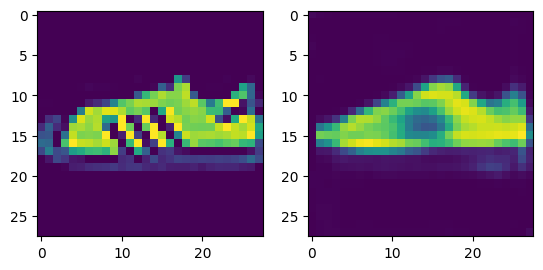

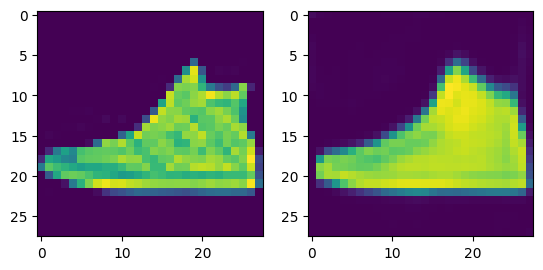

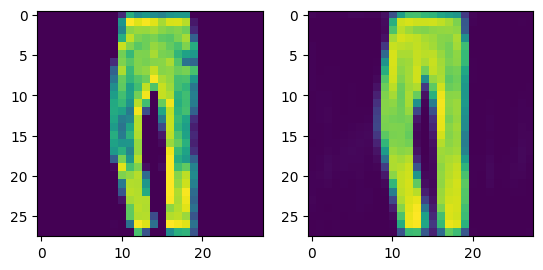

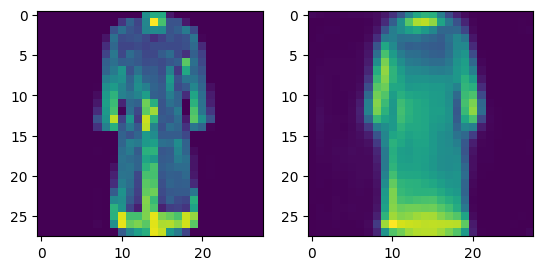

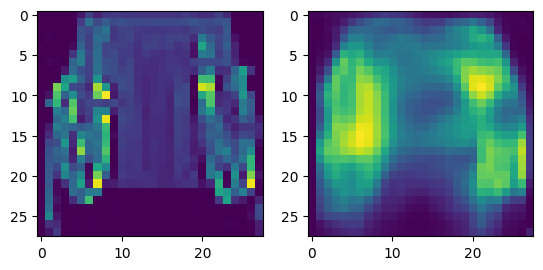

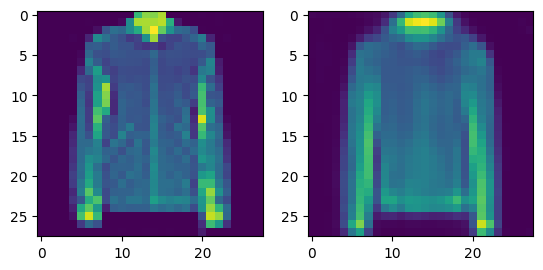

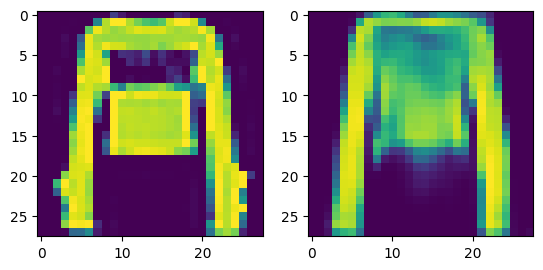

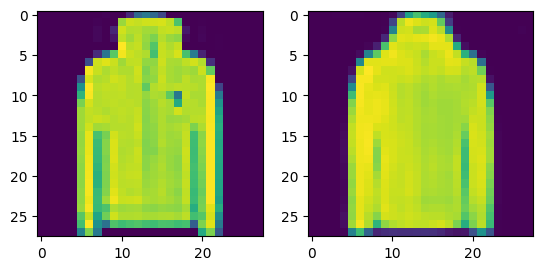

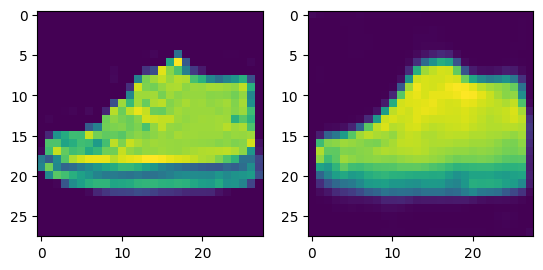

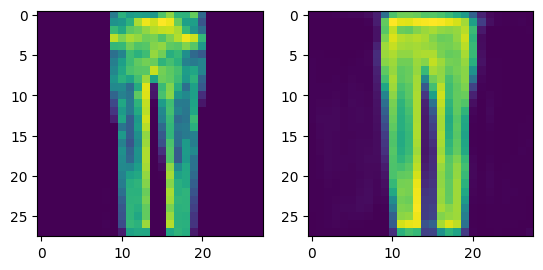

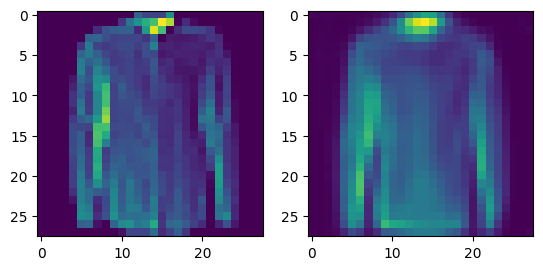

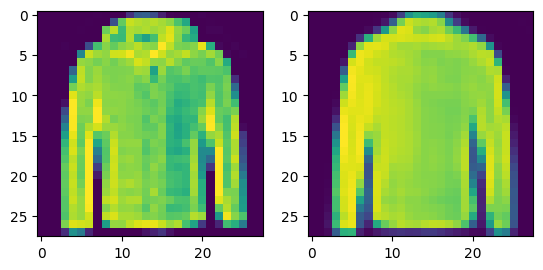

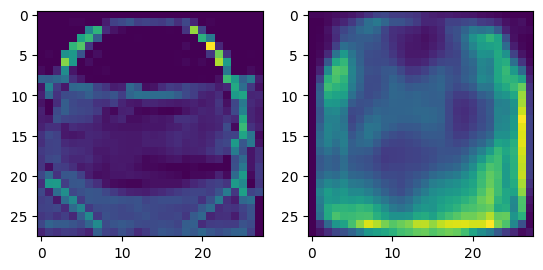

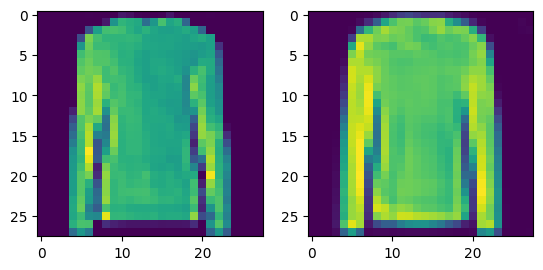

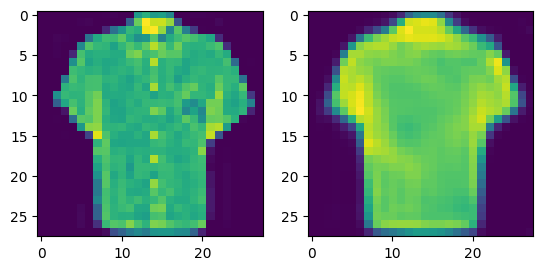

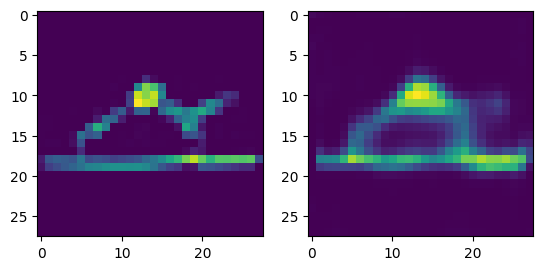

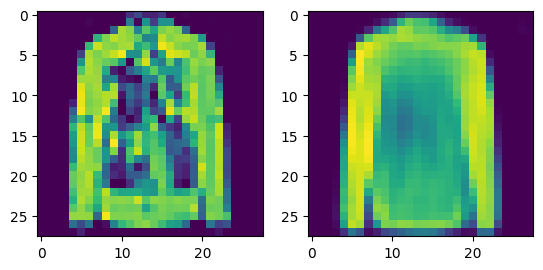

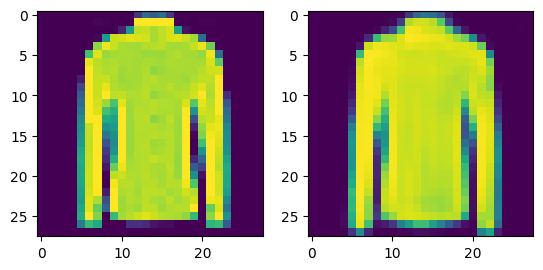

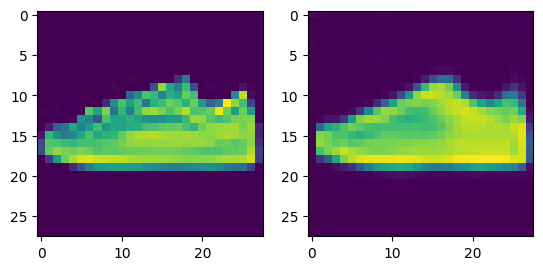

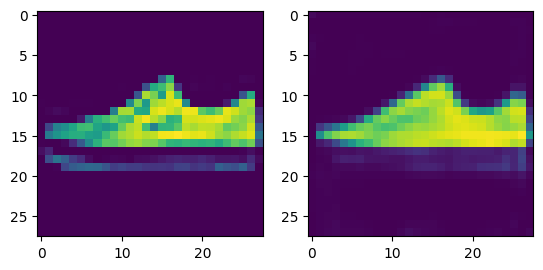

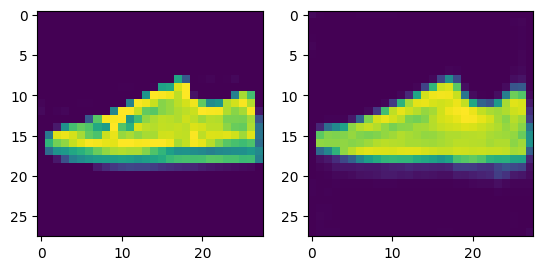

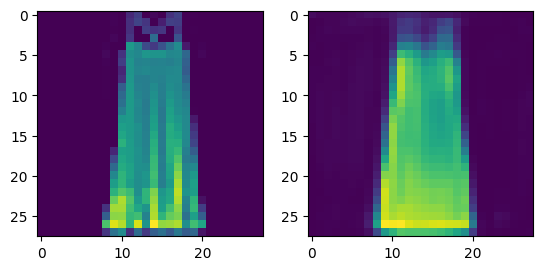

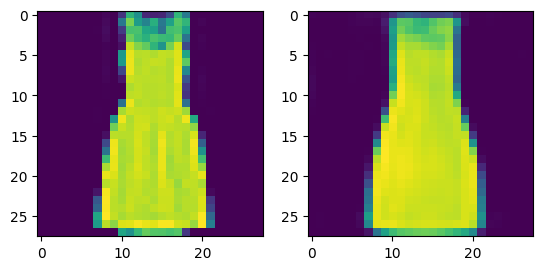

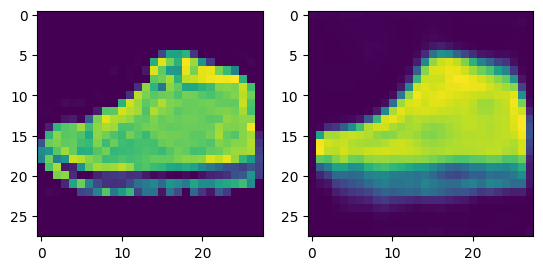

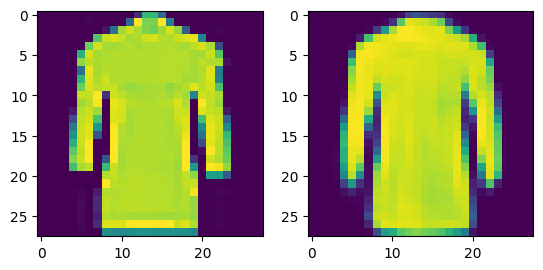

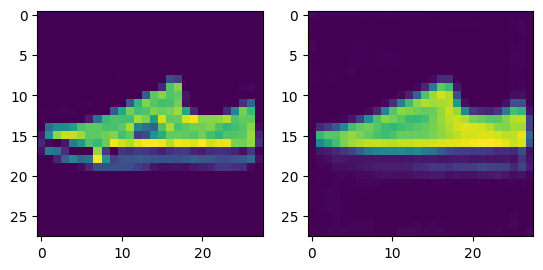

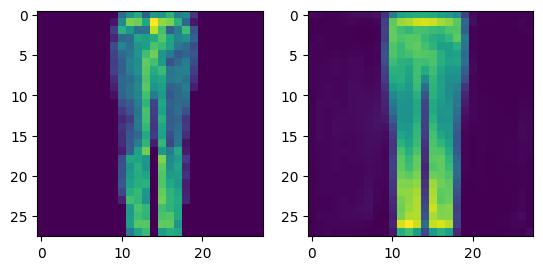

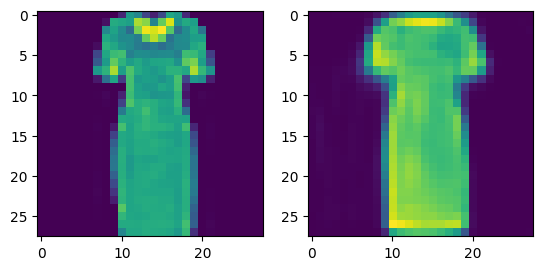

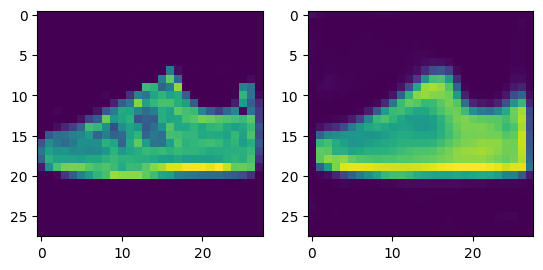

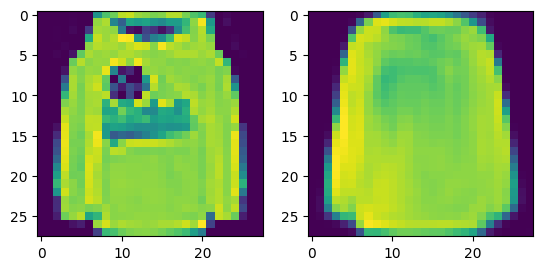

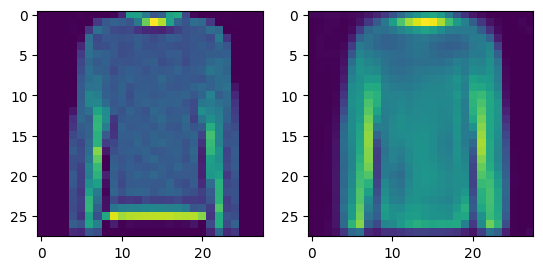

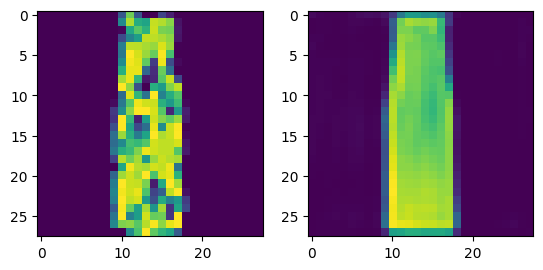

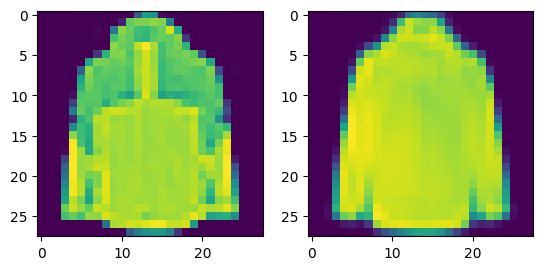

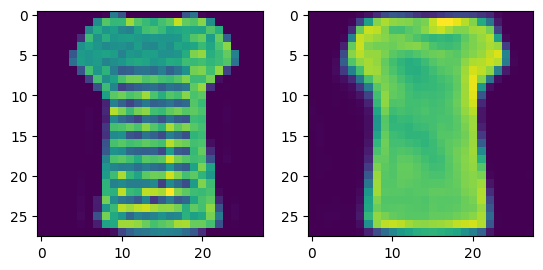

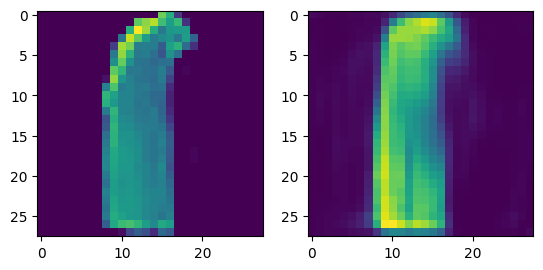

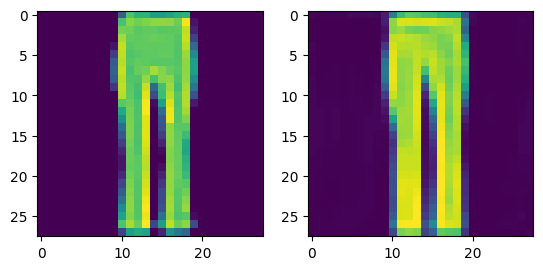

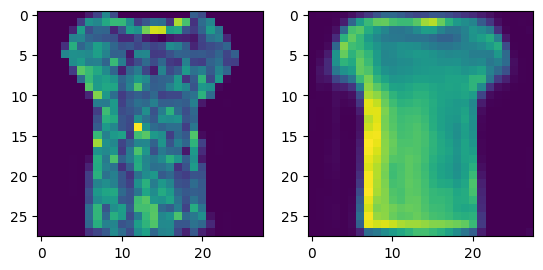

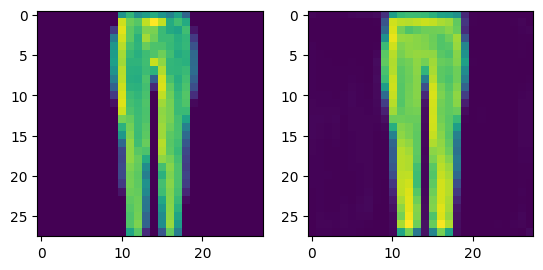

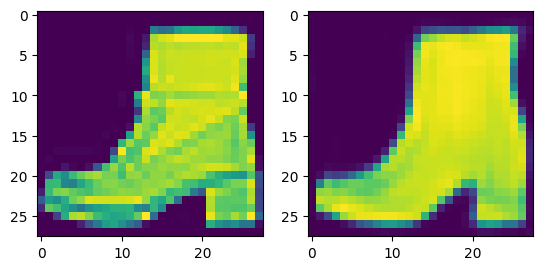

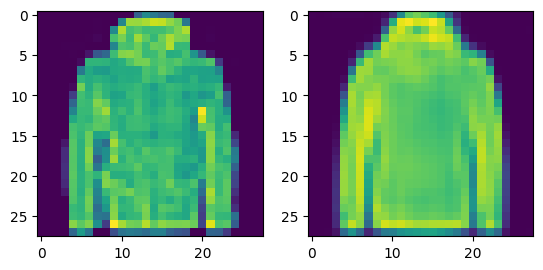

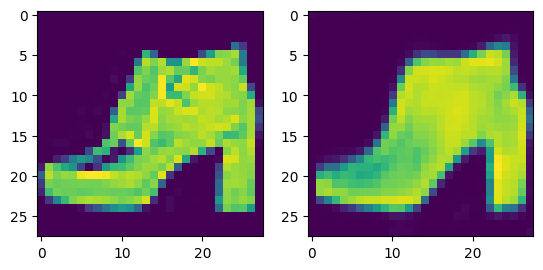

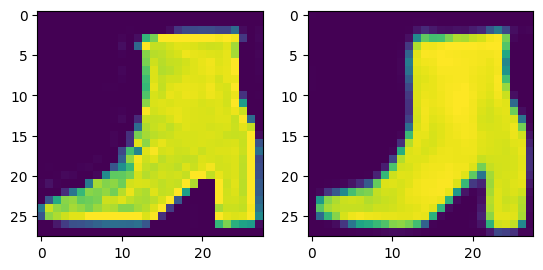

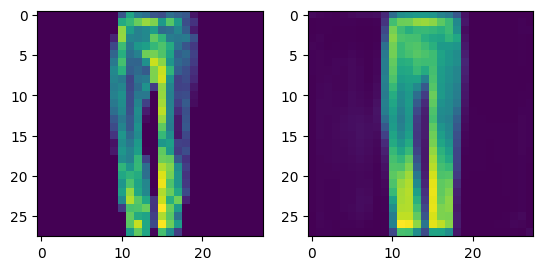

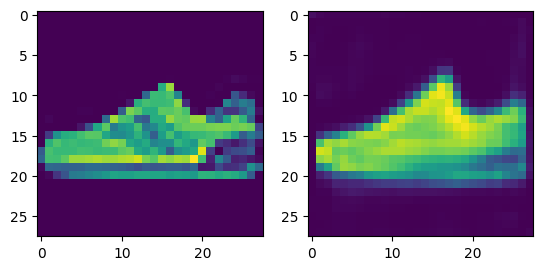

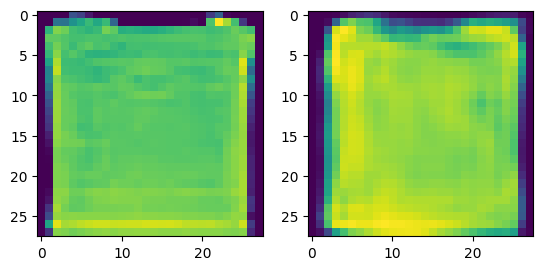

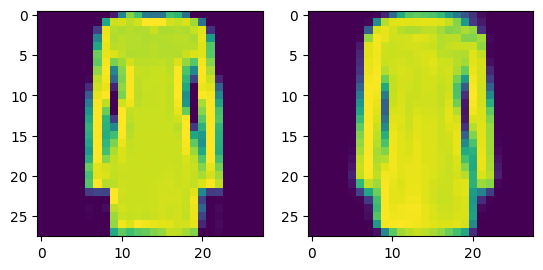

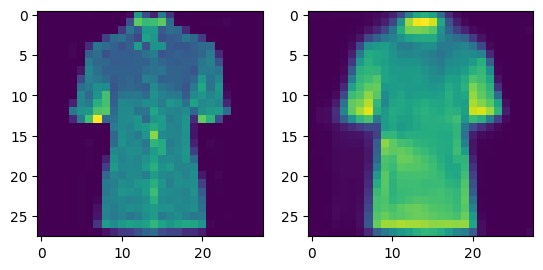

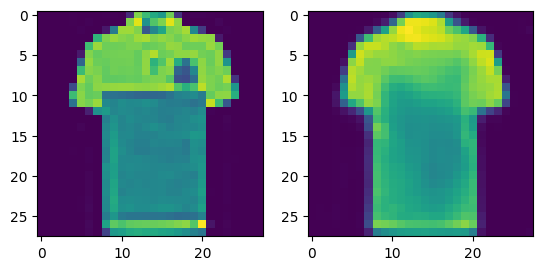

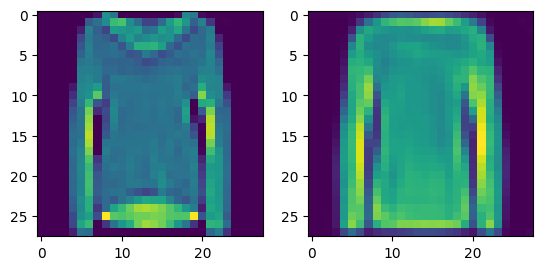

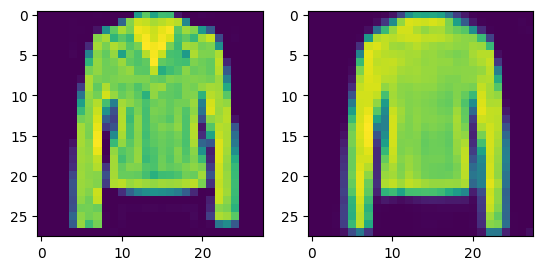

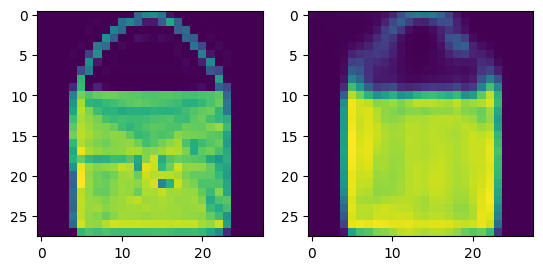

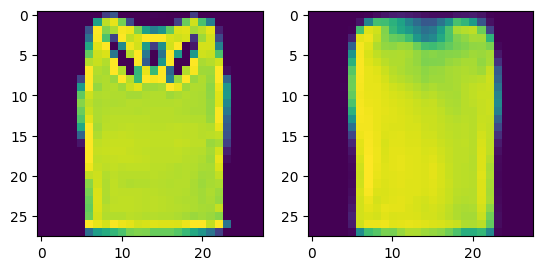

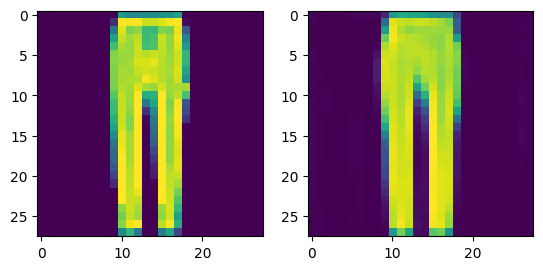

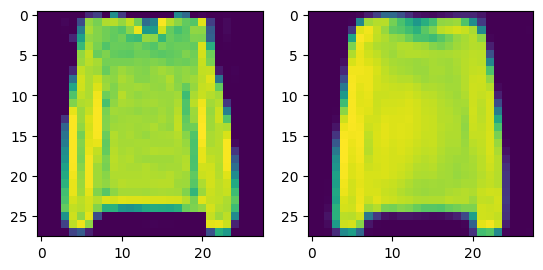

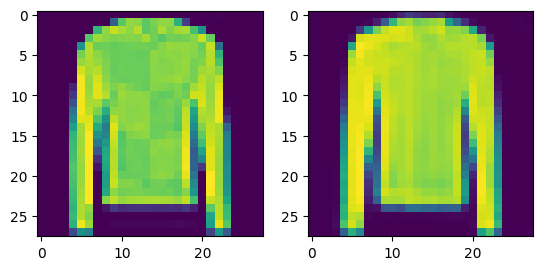

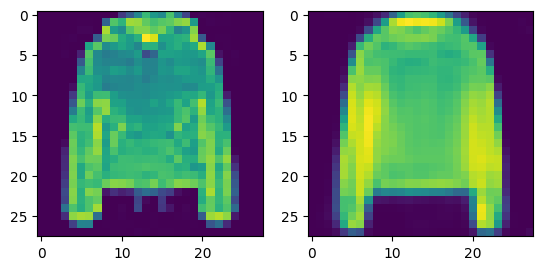

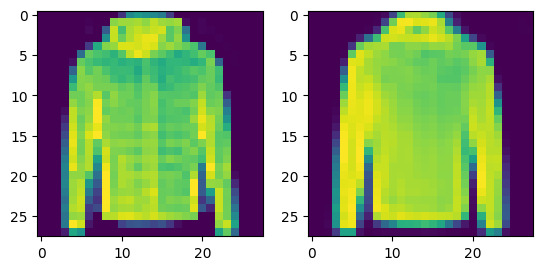

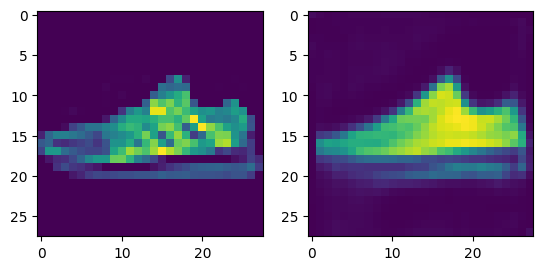

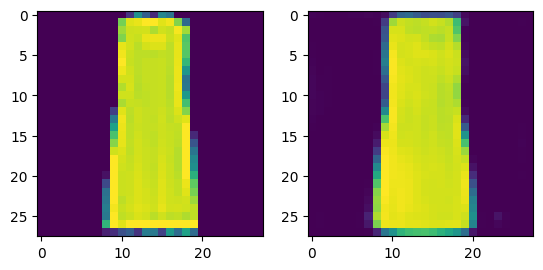

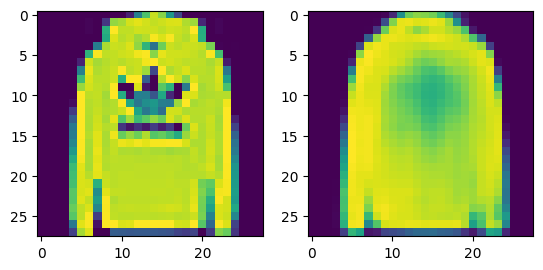

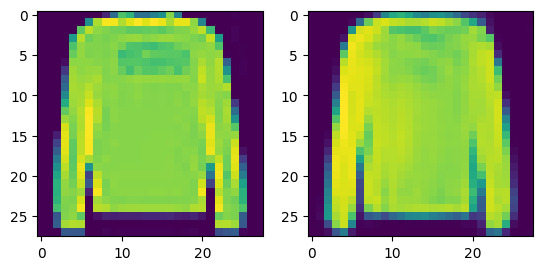

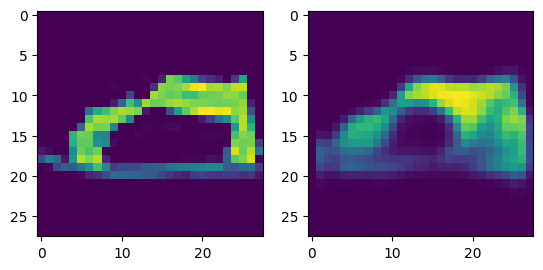

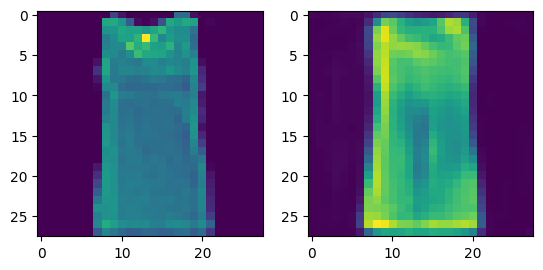

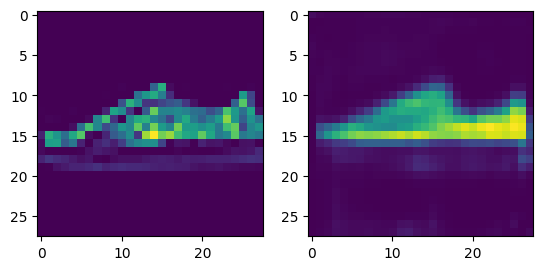

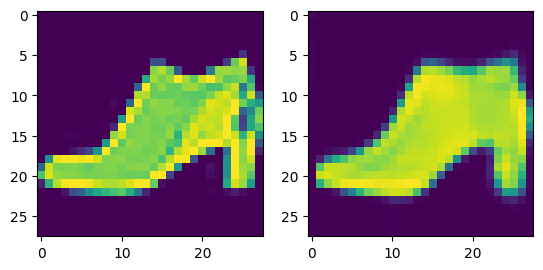

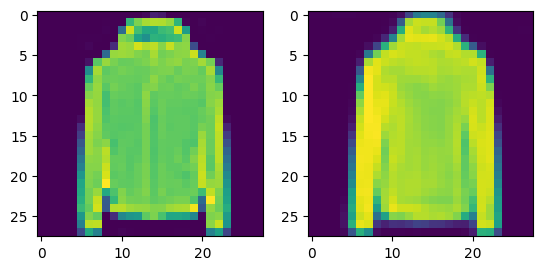

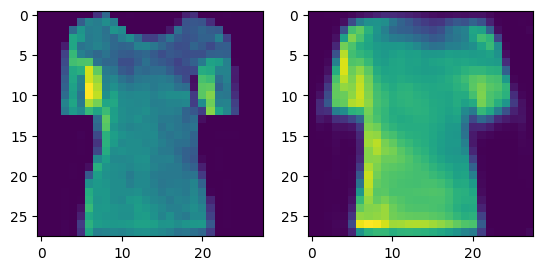

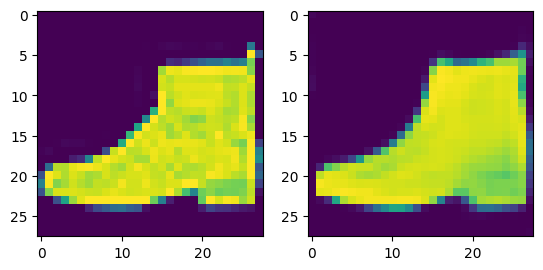

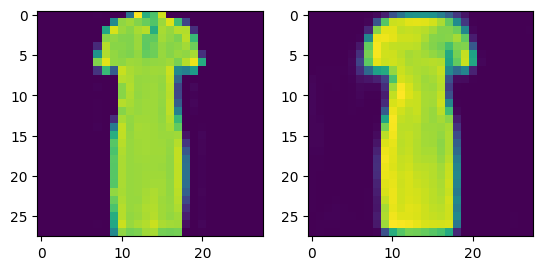

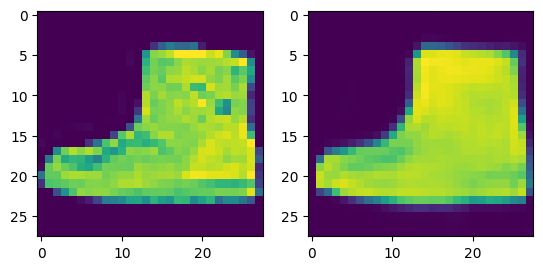

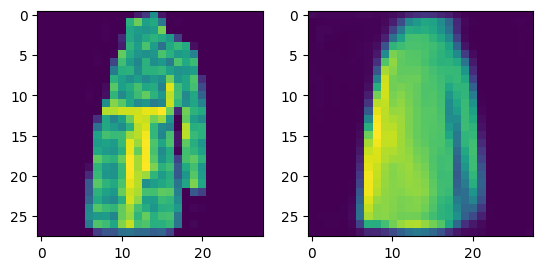

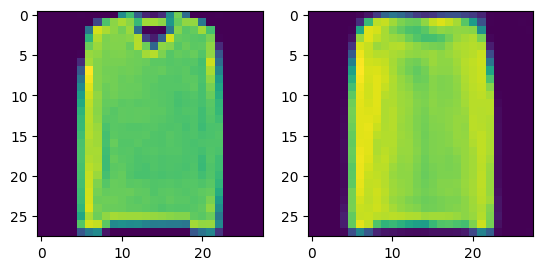

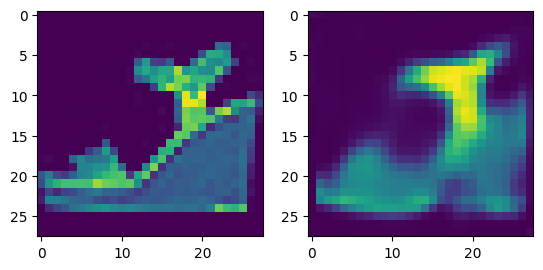

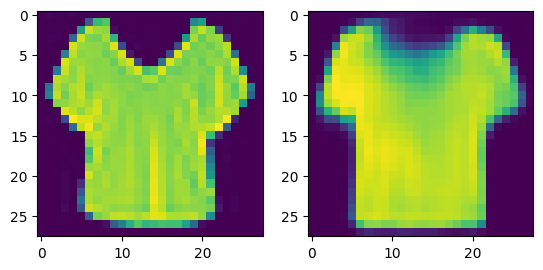

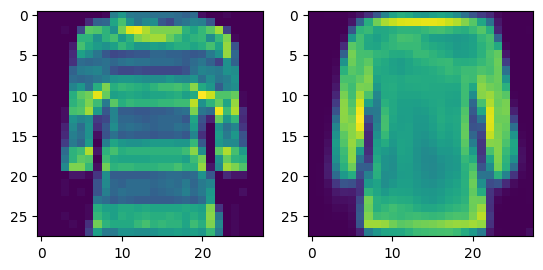

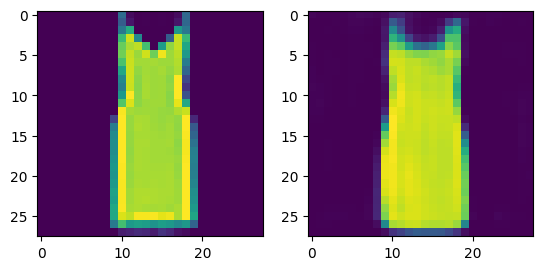

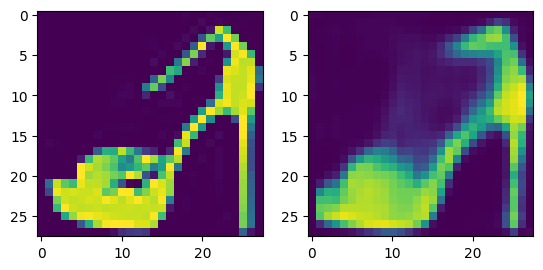

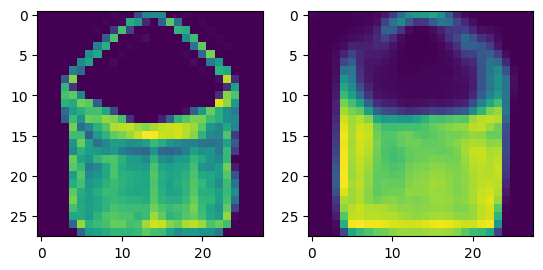

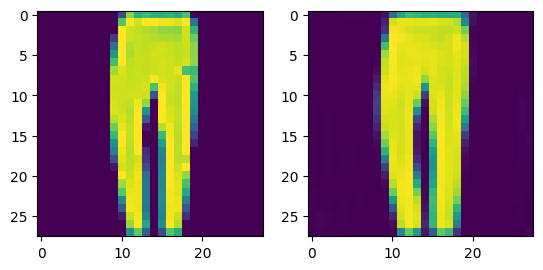

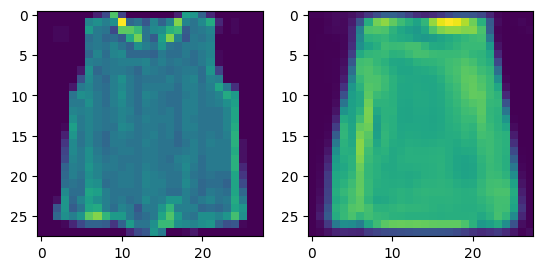

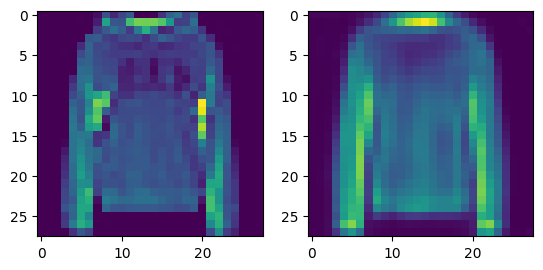

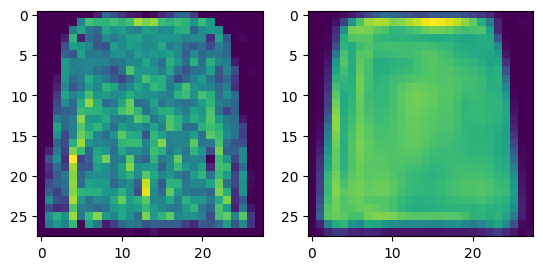

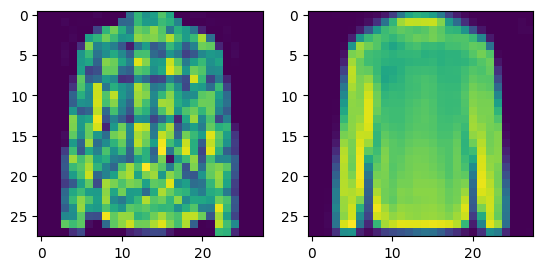

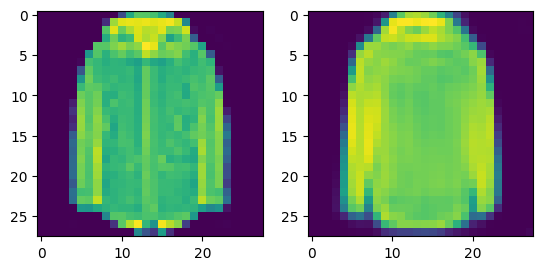

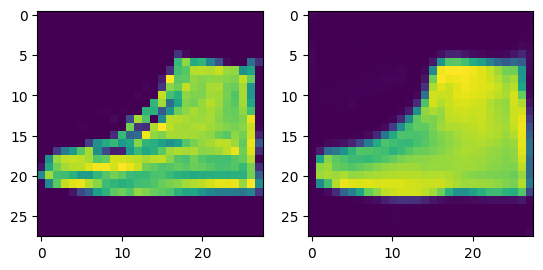

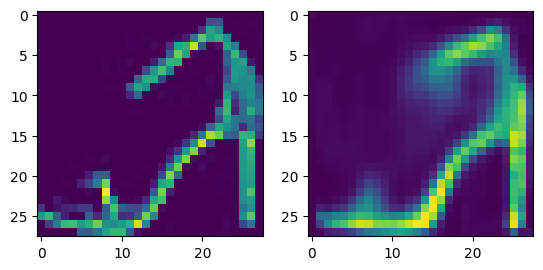

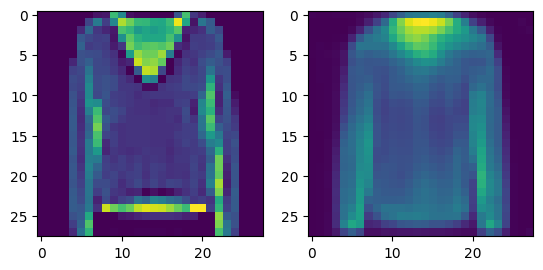

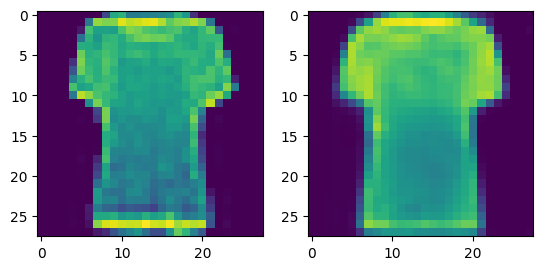

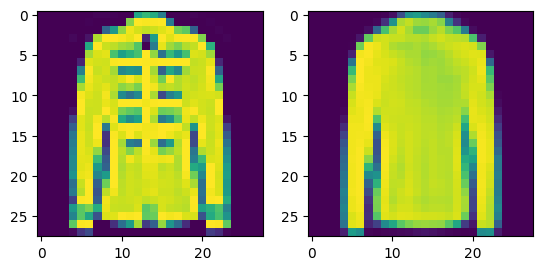

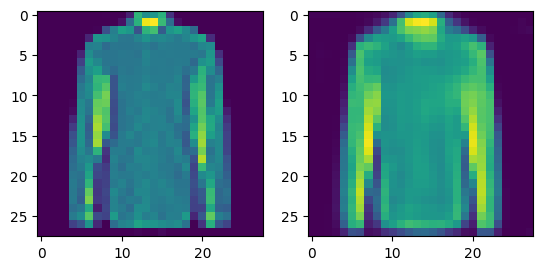

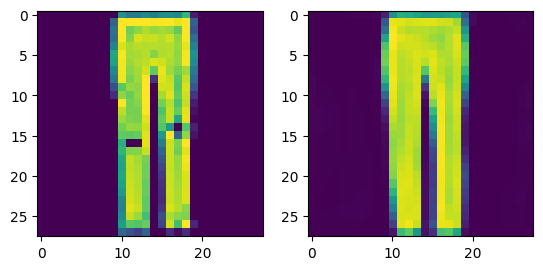

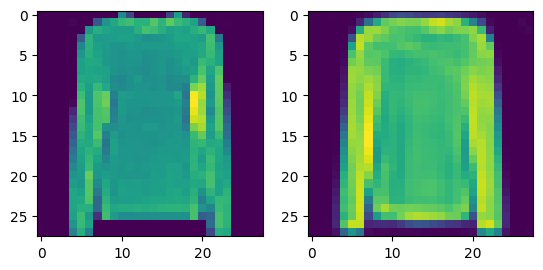

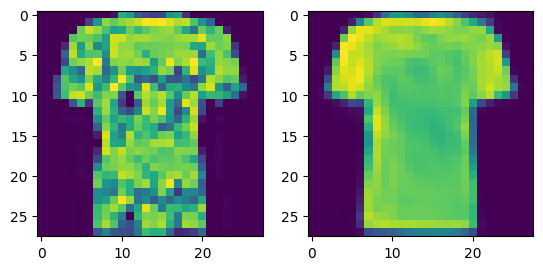

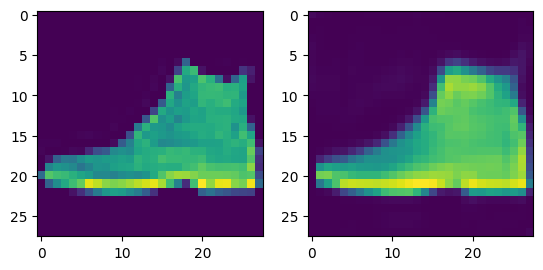

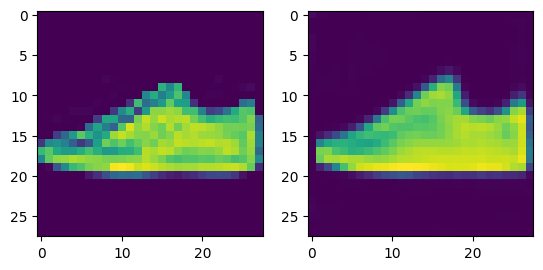

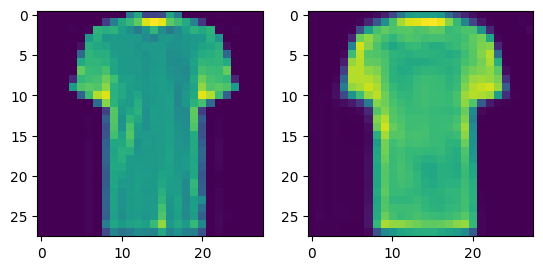

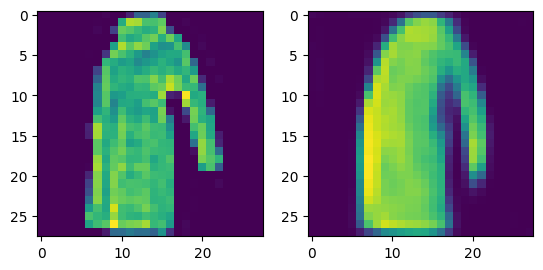

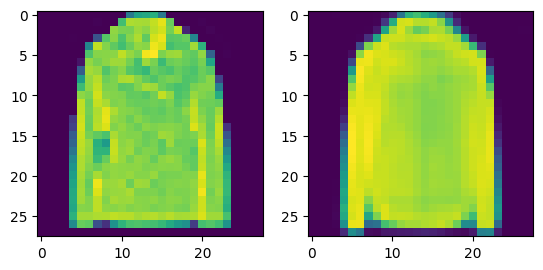

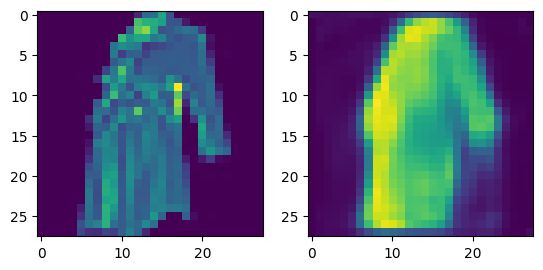

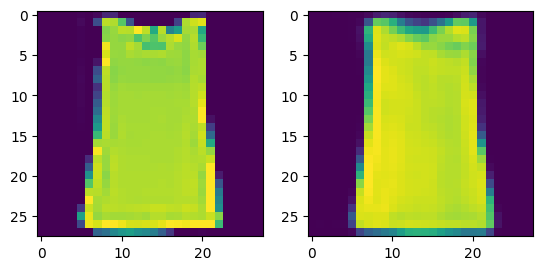

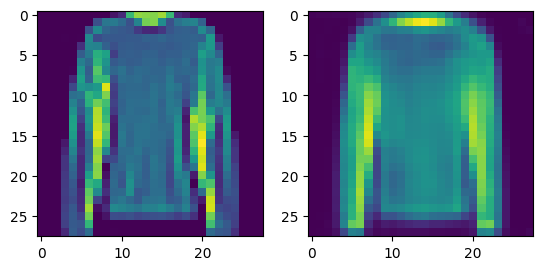

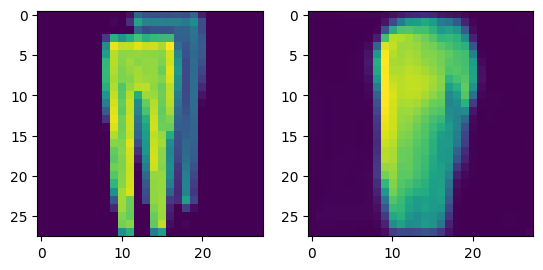

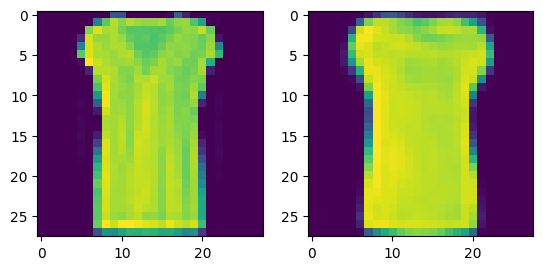

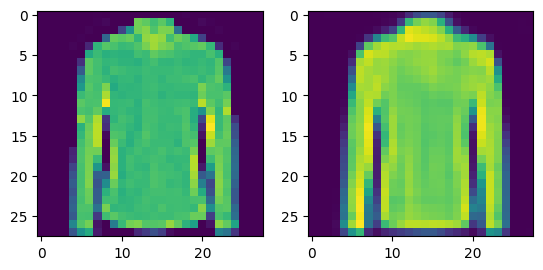

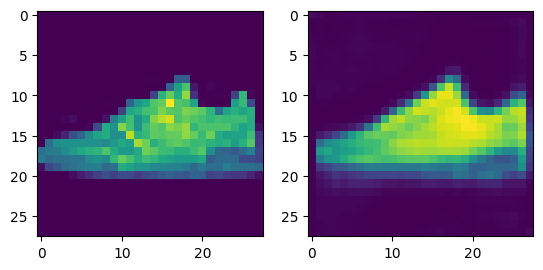

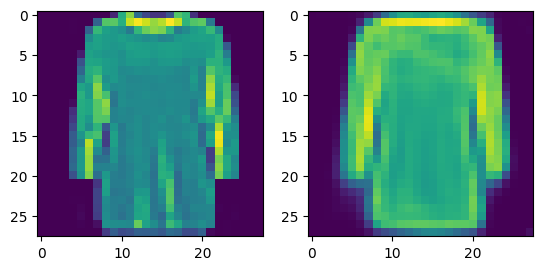

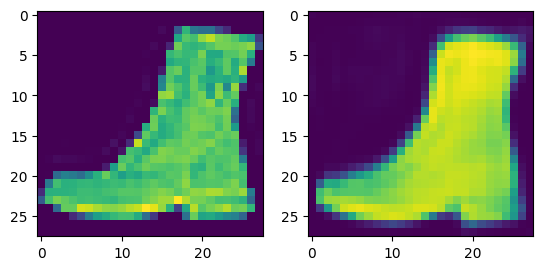

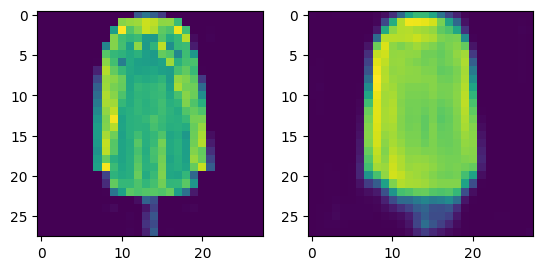

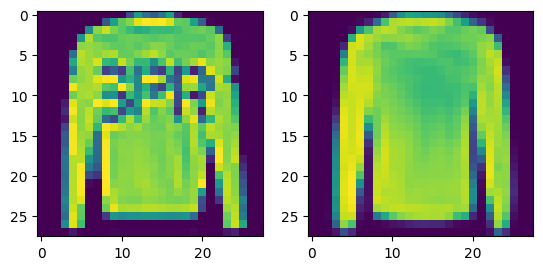

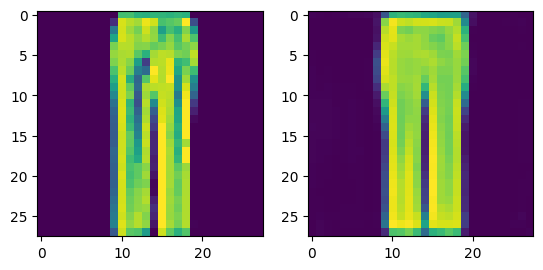

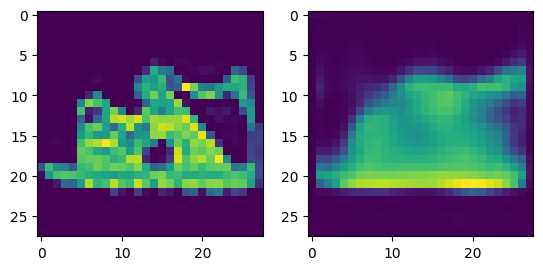

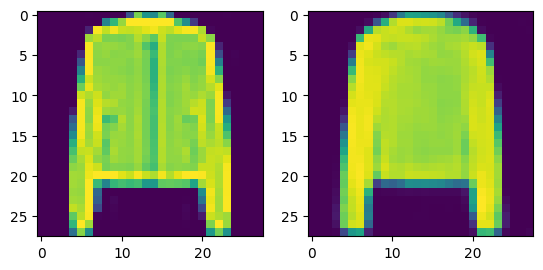

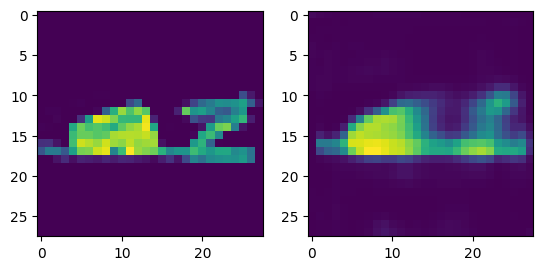

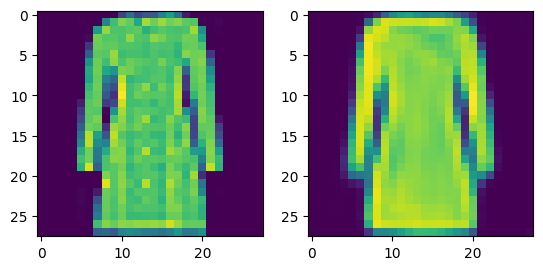

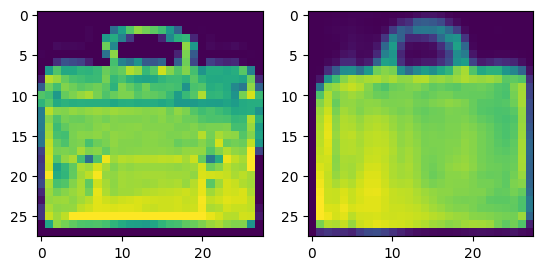

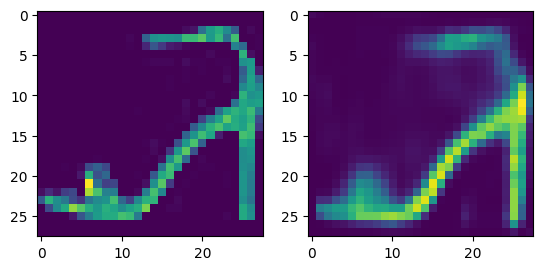

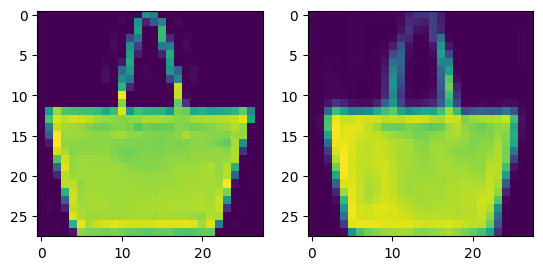

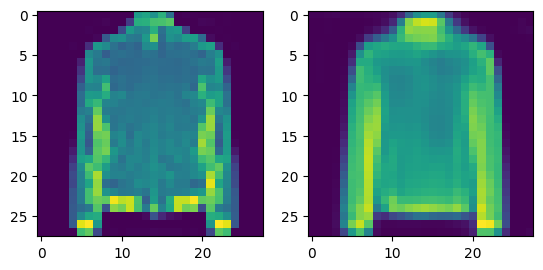

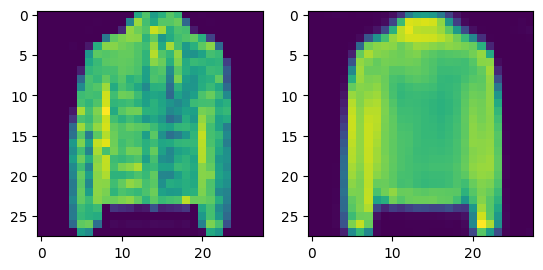

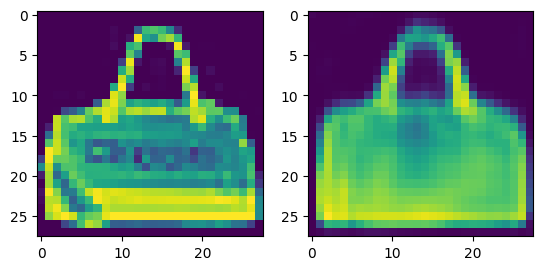

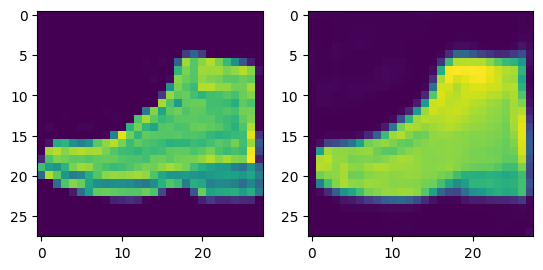

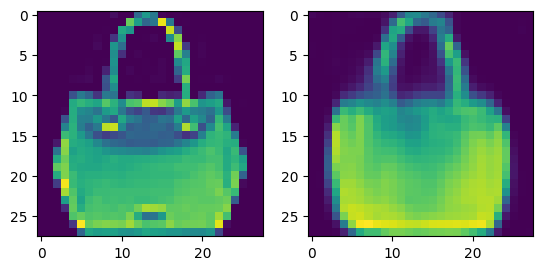

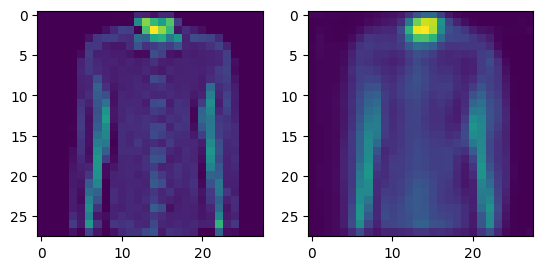

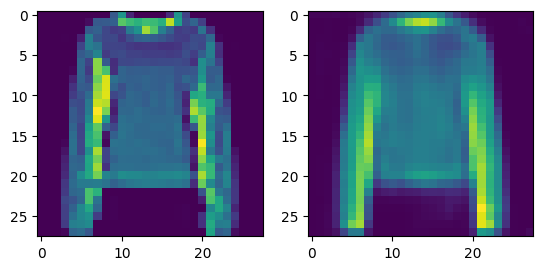

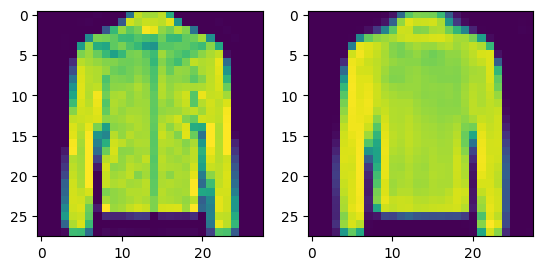

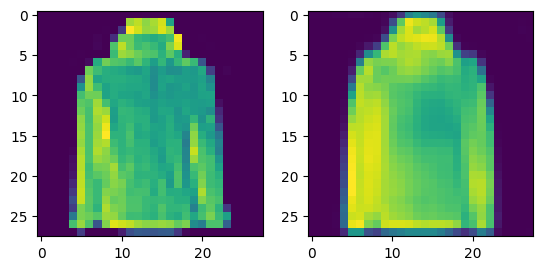

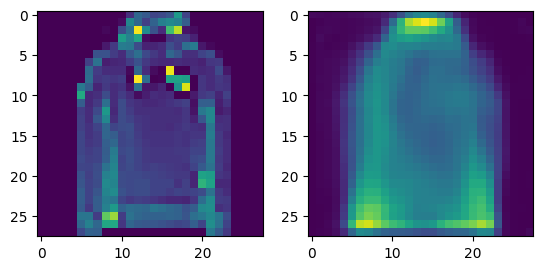

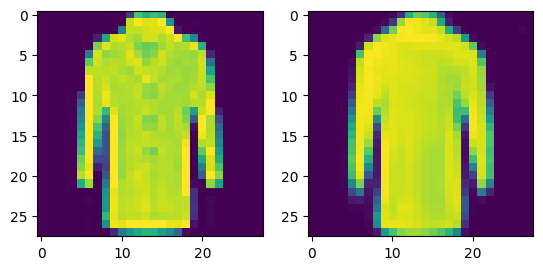

KeyboardInterrupt: 

In [59]:
import matplotlib.pyplot as plt

def image_rebuild(model):
    dataloader = DataLoader(test_data, batch_size=1)
    model.eval()
    with torch.no_grad():
        for X, _cat in dataloader:
            rebuild = model(X.to(device))
            rebuild_np = rebuild.cpu().numpy()
            _, ax = plt.subplots(1,2)
            ax[0].imshow(X[0,0])
            ax[1].imshow(rebuild_np[0,0])
            plt.show()
image_rebuild(model)